# Cutout with twin color pairs  multi colors

- author Sylvie Dagoret-Campagne
- creation date 2024-06-21
- last update 2024-06-21
- affiliation : IJCLab
- Kernel **w_2024_16**

- 1) Start by two-objects-lists sources in different bands. Thowe object are close enough to expect their visit in same calexp frequently
- 2) **Merge above visits lists**  in same band/same calexp for object 1 and Object 2 : df_g, df_r, df_z, df_y
- 3) Find closest time visit in other bands : dfg_r,

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus
from astropy.visualization import ZScaleInterval
props = dict(boxstyle='round', facecolor=None, alpha=0.1)
#props = dict(boxstyle='round')


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import scipy
from scipy.optimize import curve_fit

In [2]:
import gc

In [3]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time
import scipy

In [4]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [5]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom

#import lsst.sphgeom
from  lsst.geom import SpherePoint, Angle
import lsst.sphgeom

In [6]:

from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
import gc

import lsst.afw.display as afwDisplay
from lsst.afw.image import MultibandExposure

In [7]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [8]:
transform = AsinhStretch() + PercentileInterval(99.)

In [9]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069' # COMPLETED

collectionn = collection
#collections = [collection1,collection2,collection3]
collections = [collection]
collectionStr = collectionn.replace("/", "_")
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract = 3864 # mostly for light-curves
patch_sel = 236
#tract = 5615
# tract = 5634 # interesting to view calib parameters
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

In [10]:
#dataId = {"skymap": "latiss_v1", "tract": 5615, "instrument": "LATISS"}
dataId = {"skymap": skymapName, "tract": tract, "instrument": instrument}
repo = '/sdf/group/rubin/repo/oga/'
butler = dafButler.Butler(repo)
#t = Butler.get(table_sel, dataId=dataId, collections=collections)
registry = butler.registry

In [11]:
skymap_auxtel ='latiss_v1'
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=collections)

In [12]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [13]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [14]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

In [15]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

In [16]:
def cutout_calexp(butler, ra, dec, visit, detector, cutoutSideLength=51, **kwargs):
    
    """
    Produce a cutout from a calexp at the given ra, dec position.

    Adapted from cutout_coadd which was adapted from a DC2 tutorial
    notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    visit: int
        Visit id of the calexp's visit
    detector: int
        Detector for the calexp
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    
    dataId = {'visit': visit, 'detector': detector}    
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)    
    calexp_wcs = butler.get('calexp.wcs', **dataId)
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    cutout_image = butler.get('calexp', parameters=parameters, **dataId)

    return cutout_image

In [17]:
def create_rgb(image, bgr="gri", stretch=1, Q=10, scale=None):
    """
    Create an RGB color composite image.

    Parameters
    ----------
    image : `MultibandExposure`
        `MultibandExposure` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e., keys of the exps dict)
        indicating what band to use for each channel. If `image` only has
        three filters then this parameter is ignored and the filters
        in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales the RGB channels.

    Returns
    -------
    rgb: ndarray
        RGB (integer, 8-bits per channel) colour image as an NxNx3 numpy array.
    """

    # If the image only has 3 bands, reverse the order of the bands
    #   to produce the RGB image
    if len(image) == 3:
        bgr = image.filters

    # Extract the primary image component of each Exposure with the
    #   .image property, and use .array to get a NumPy array view.

    if scale is None:
        r_im = image[bgr[2]].array  # numpy array for the r channel
        g_im = image[bgr[1]].array  # numpy array for the g channel
        b_im = image[bgr[0]].array  # numpy array for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]].array * scale[0]
        g_im = image[bgr[1]].array * scale[1]
        b_im = image[bgr[0]].array * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

In [18]:
def find_neighbourg(ra0,dec0,src):
    """ 
    """
    all_angles = []
    for index, row in src.iterrows():
        spherePointCenter = lsst.geom.SpherePoint(ra0*lsst.geom.degrees, dec0*lsst.geom.degrees)
        spt = lsst.geom.SpherePoint(row["ra"]*lsst.geom.degrees, row["dec"]*lsst.geom.degrees)
        ang = spherePointCenter.separation(spt)
        ang_arcsec = ang.asArcseconds()
        all_angles.append(ang_arcsec)
    return all_angles

In [19]:
def PlotAndFitHisto(data,std_clip,ax,nbins=50,xlabel=r'$(G-R)_1 - (G-R)_2$ :',title="Differential color with 2 stars",xmin=-100.,xmax=100.):
    #data = df_col_gr["ratio3"].values

    hist, bin_edges = np.histogram(data,bins=nbins,range=(xmin,xmax),density=True)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [1., 0., 1.]

    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

    # Get the fitted curve
    hist_fit = gauss(bin_centres, *coeff)

    textstr = '\n'.join((
    xlabel,
    r'$\sigma_{clipped} = %.01f$ mmag' %(std_clip,),
    r'$\sigma_{fit} = %.01f$ mmag' %(coeff[2], )))

    ax.step(bin_centres, hist,'k' ,label='data')
    ax.plot(bin_centres, hist_fit,'r-', label='fit')
    ax.set_xlabel(xlabel)
    ax.legend()
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="blue", weight='bold',bbox=props)
    ax.set_title(title)
    ax.set_xlim(xmin,xmax)
    # Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
    #print('Fitted mean = ', coeff[1])
    #print('Fitted standard deviation = ', coeff[2])

## Get Pixel Scale

In [20]:
import lsst.geom as geom
import lsst.sphgeom

skymap = butler.get('skyMap', skymap=skymapName, collections=collections )
tractInfo = skymap.generateTract(tract)
for patch in tractInfo:    
    patchID = patch.getSequentialIndex()
        
    ibb=patch.getInnerBBox()
    tWCS=tractInfo.getWcs()
       
    # loop on the 4 corners
    for icorn,corner in enumerate(ibb.getCorners()):
        p = geom.Point2D(corner.getX(), corner.getY())
        coord = tWCS.pixelToSky(p)

In [21]:
tWCS

FITS standard SkyWcs:
Sky Origin: (122.4365482234, -36.4462809917)
Pixel Origin: (28499, 28499)
Pixel Scale: 0.1 arcsec/pixel

In [22]:
#arcsec/pixel
pixel_scale = tWCS.getPixelScale().asArcseconds()

## Selected visits

### Spectroscopy

In [23]:
atmfilename = "data/spectro/auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_testWithMaskedEdges_newBoundaries_newPolysRescaled_newFitBounds_adjustA1_lockedOrder2_removeThroughputTails_2.npy"

In [24]:
specdata = np.load(atmfilename,allow_pickle=True)

In [25]:
df_spec = pd.DataFrame(specdata)
df_spec

,DATE-OBS,id,BITPIX,NAXIS,NAXIS1,NAXIS2,EXTEND,TARGET,REDSHIFT,GRATING,ROTANGLE,D2CCD,LSHIFT,PARANGLE,TARGETX,TARGETY,LBDA_REF,PSF_REG,TRACE_R,MEANFWHM,PIXSHIFT,CHI2_FIT,A2_FIT,AM_FIT,VERSION,CCD_REBIN,CONFIG,EXPTIME,AIRMASS,DEC,HA,OUTTEMP,OUTPRESS,OUTHUM,FILTER,CAM_ROT,S_X0,S_Y0,S_XMIN,S_XMAX,S_YMIN,S_YMAX,S_NX,S_NY,S_DEG,S_SAT,S_ORDER,A1_x,A1_err_x,A2_x,A2_err_x,A3,A3_err,VAOD_x,VAOD_err_x,angstrom_exp_x,angstrom_exp_err_x,ozone [db]_x,ozone [db]_err_x,PWV [mm]_x,PWV [mm]_err_x,B_x,B_err_x,A_star,A_star_err,D_CCD [mm]_x,D_CCD [mm]_err_x,shift_x [pix],shift_x [pix]_err,shift_y [pix],shift_y [pix]_err,angle [deg],angle [deg]_err,x_c_0_1,x_c_0_1_err,x_c_1_1,x_c_1_1_err,x_c_2_1,x_c_2_1_err,y_c_0_1,y_c_0_1_err,y_c_1_1,y_c_1_1_err,y_c_2_1,y_c_2_1_err,gamma_0_1,gamma_0_1_err,gamma_1_1,gamma_1_1_err,gamma_2_1,gamma_2_1_err,alpha_0_1,alpha_0_1_err,alpha_1_1,alpha_1_1_err,alpha_2_1,alpha_2_1_err,saturation_0_1,saturation_0_1_err,x_c_0_2,x_c_0_2_err,x_c_1_2,x_c_1_2_err,x_c_2_2,x_c_2_2_err,y_c_0_2,y_c_0_2_err,y_c_1_2,y_c_1_2_err,y_c_2_2,y_c_2_2_err,gamma_0_2,gamma_0_2_err,gamma_1_2,gamma_1_2_err,gamma_2_2,gamma_2_2_err,alpha_0_2,alpha_0_2_err,alpha_1_2,alpha_1_2_err,alpha_2_2,alpha_2_2_err,saturation_0_2,saturation_0_2_err,x_c_0_3,x_c_0_3_err,x_c_1_3,x_c_1_3_err,x_c_2_3,x_c_2_3_err,y_c_0_3,y_c_0_3_err,y_c_1_3,y_c_1_3_err,y_c_2_3,y_c_2_3_err,gamma_0_3,gamma_0_3_err,gamma_1_3,gamma_1_3_err,gamma_2_3,gamma_2_3_err,alpha_0_3,alpha_0_3_err,alpha_1_3,alpha_1_3_err,alpha_2_3,alpha_2_3_err,saturation_0_3,saturation_0_3_err,A1_y,A1_err_y,A2_y,A2_err_y,VAOD_y,VAOD_err_y,angstrom_exp_y,angstrom_exp_err_y,ozone [db]_y,ozone [db]_err_y,PWV [mm]_y,PWV [mm]_err_y,reso [nm],reso [nm]_err,D_CCD [mm]_y,D_CCD [mm]_err_y,alpha_pix [pix],alpha_pix [pix]_err,B_y,B_err_y
0,2023-01-18 02:33:44.320492641+00:00,2023011700238,-64,2,1136,3,True,HD185975,-0.000065,holo4_003,0.149105,187.115733,0.0,139.709895,146.034375,882.149820,619.643455,14.563485,93.783944,10.355760,1.160026,10.840887,0.0,2.094160,3.1.0,2,,30.0,2.094160,-87.507430,-221.203268,10.00,743.00,NaN,empty,41.849028,-417.516831,19.149820,560,1696,863,908,1136,45,2,22666.666667,1,0.664441,0.005724,1.0,0.0,0.0,0.0,0.050687,0.004121,0.303824,0.028039,359.623063,1.770352,4.483119,0.020971,1.0,0.0,1.0,0.0,187.034266,0.008275,1.277989,0.041836,-0.193538,0.0,0.139924,0.0,986.182943,0.0,567.524178,0.0,-0.023856,0.0,-0.035756,0.000813,0.020469,0.001938,0.315324,0.004637,15.322203,0.015657,-4.534772,0.016222,-13.475017,0.036052,5.494988,0.008192,-0.822629,0.006912,-5.679592,0.016640,22666.666667,0.0,986.182943,0.0,567.524178,0.0,-0.023856,0.0,0.362173,0.177561,-2.036786,0.642700,-3.179989,0.568601,28.027856,0.970177,0.0,0.0,0.0,0.0,10.000000,0.602072,0.0,0.0,0.0,0.0,22666.666667,0.0,986.182943,0.0,567.524178,0.0,-0.023856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.023469,0.0,0.0,0.0,0.0,0.0,8.988875,0.0,0.0,0.0,0.0,0.0,22666.666667,0.0,0.735193,0.701231,0.0,0.0,0.094037,0.459493,0.181265,0.997354,382.709734,9.364816,4.971505,0.064734,1.024480,0.027735,187.113505,0.004147,1.160026,0.0,0.0,0.0
1,2023-01-18 02:34:27.138506292+00:00,2023011700239,-64,2,1137,3,True,HD185975,-0.000065,holo4_003,0.138871,187.076469,0.0,139.885619,144.051156,882.564567,619.643455,0.228823,53.345136,10.918251,0.101144,4.849593,0.0,2.094525,3.1.0,2,,30.0,2.094525,-87.507439,-221.024162,10.00,743.00,NaN,empty,41.849066,-417.179307,19.564567,559,1696,863,908,1137,45,2,22666.666667,1,0.606995,0.000447,1.0,0.0,0.0,0.0,0.000000,0.000446,1.275747,0.000000,266.588883,1.690057,3.330756,0.018129,1.0,0.0,1.0,0.0,187.330383,0.004054,0.136300,0.009280,-0.058637,0.0,0.138740,0.0,985.285378,0.0,568.022658,0.0,-0.022383,0.0,-0.130373,0.000763,0.008003,0.002190,1.141302,0.004924,11.201134,0.010199,-0.512261,0.026190,3.048078,0.058986,3.454636,0.003848,0.508409,0.011071,1.073220,0.023461,22666.666667,0.0,985.285378,0.0,568.022658,0.0,-0.022383,0.0,-0.349097,0.155047,-5.994891,0.536350,-8.025680,0.457910,11.666854,0.096594,0.0,0.0,0.0,0.0,3.321643,0.034542,0.0,0.0,0.0

In [26]:
df_spec["Time"] = pd.to_datetime(df_spec["DATE-OBS"])
df_spec["PWV [mm]_x"]

0       4.483119
1       3.330756
2       2.742911
3       2.843021
4       4.360064
          ...   
3400    6.666181
3401    5.331670
3402    5.794519
3403    4.958871
3404    4.867175
Name: PWV [mm]_x, Length: 3405, dtype: float64

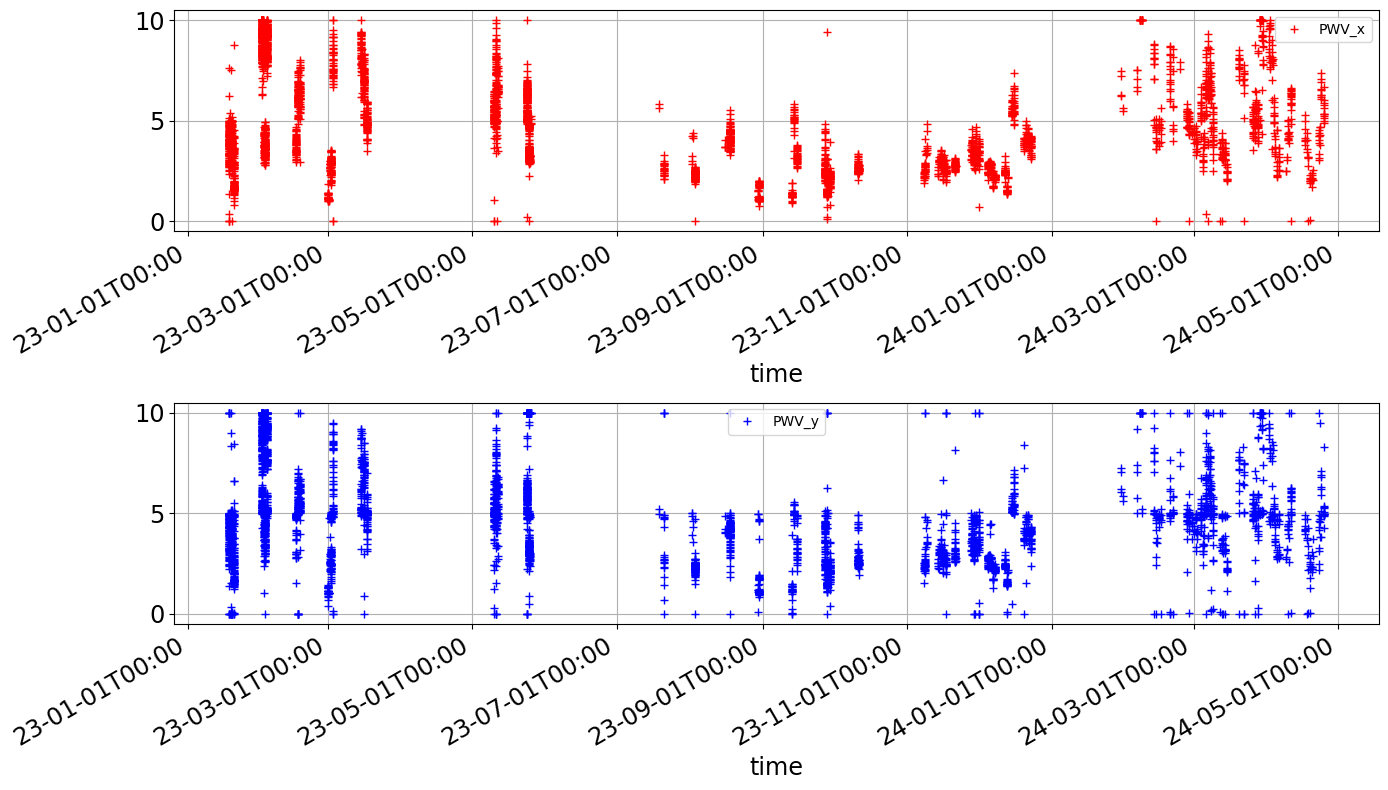

In [27]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(2,1,figsize=(14,8))
ax1,ax2  = axs
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="PWV_x")
df_spec.plot(x="Time",y="PWV [mm]_y",ax=ax2,marker='+',c="b",lw=0.0,grid=True,label="PWV_y")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax2.set_xlabel("time")
ax2.xaxis.set_major_formatter(date_form)
plt.tight_layout()

### Photometry

- paires de couleur différentes (617,647)
- paires de même couleurs (373,488)

In [28]:
!ls *.csv

all_pairs.csv
list_of_isolatedobjects.csv
objectTable-t3864-bg-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv
objectTable-t3864-bg-o547-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv
objectTable-t3864-bg-o912-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv
objectTable-t3864-br-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv
objectTable-t3864-by-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv
objectTable-t3864-bz-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv
objectTable-t3864-multiband-o912-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv
objectTable-t9880-bg-LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612.csv
sources_objectTable-t3864-bg-o547-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv
sources_objectTable-t3864-bg-o912-LATISS_runs_AUXTEL_DRP_IMAGI

In [29]:
df_pair = pd.read_csv("all_pairs.csv",index_col=0)
df_pair.head()

,objidx1,objidx2,G1_R1,G2_R2,Z1_Y1,Z2_Y2,sep
694,158.0,910.0,0.739111,0.987084,-0.116571,NaN,7.954936
1893,617.0,647.0,0.543391,0.347490,-0.203188,-0.020987,10.576022
379,121.0,240.0,0.545134,0.151336,-0.111061,0.007964,16.130015
2049,882.0,954.0,0.867764,1.373554,-0.174242,NaN,16.857574
16,60.0,240.0,0.483214,0.151336,-0.088688,0.007964,18.286541


In [30]:
idx_pair = 0
objectname1 = int(df_pair["objidx1"].iloc[idx_pair])
objectname2 = int(df_pair["objidx2"].iloc[idx_pair])

In [31]:
#inputfilename = "sources_objectTable-t3864-multibands-o912-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv"

## The two lists:
path_photom ="data/photom/sources_objectTable"
tract = 3864

inputfilename ="objects-lightcurves-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069-tract3864.csv"
inputfullfilename= os.path.join(path_photom,inputfilename) 

df_allsources = pd.read_csv(inputfullfilename,index_col=0)

#pair_name = f"p{objectname1}-{objectname2}"
#path = f"calexp_t{tract}_allband_o{objectname1}_{objectname2}"
#title = f"Auxtel Light Curves : tract = {tract}, objectIdx = {objectname1}, {objectname2} "
#suptitle = inputfilename 

In [32]:
df_allsources.head()

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,apFlux_50_0_calFlux,apFlux_50_0_calFluxErr,apFlux_50_0_calMag,apFlux_50_0_calMagErr,psfInstMag,psfInstMagErr,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas,localPhotoCalibMag,localPhotoCalibMagErr,DZP
0,179300073413279749,1.590427e+06,12951.962007,False,1.019180,0.0,0.0,True,False,1.627483e+06,16530.075939,False,45.186953,0.090804,False,4,2023121500478,0,122.616310,-36.190488,SDSSz_65mm~empty,z,35957.226770,617.848502,3577.161135,50.744859,37554.299549,870.651580,False,0.285867,False,4,526,122.794318,15.896215,0.008842,1.624798e+06,27918.691042,15.873002,0.018656,1.696964e+06,39342.091752,15.825818,0.025171,20.033748,0.008842,0.977231,42748468736,2023121500478,z,21.00044,27.282501,4.202831,13.336939,8.06057,0.027859,0.011082,62,-0.000778,-0.002066,0.015893,0.00986,0.010462,0.077073,0.0184,0.544138,2171.611,0.284355,0.056613,2.249392,0.074432,-36.139215,0,0.947236,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.002208,0.051613,-0.051273,-307.066273,-7.029632,41.469376,-13.767346,16.766397,27.262467,0.002182,-0.020034
1,179300073413279764,1.745098e+06,14092.440598,False,1.011197,0.0,0.0,True,False,1.740110e+06,16045.611396,False,44.329708,0.090804,False,19,2023121500478,0,122.585459,-36.189035,SDSSz_65mm~empty,z,38141.482273,714.174432,2641.422154,117.690669,36552.223725,1007.246250,False,-0.151407,False,19,214,123.832235,15.795450,0.008768,1.690801e+06,31659.144081,15.829769,0.020330,1.620349e+06,44650.932225,15.875978,0.029919,19.912187,0.008768,1.002867,42748468736,2023121500478,z,21.00044,27.282501,4.202831,13.336939,8.06057,0.027859,0.011082,62,-0.000778,-0.002066,0.015893,0.00986,0.010462,0.077073,0.0184,0.544138,2171.611,0.284355,0.056613,2.249392,0.074432,-36.139215,0,0.947236,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.002208,0.020762,-0.049820,-204.374556,-6.497087,-3.833432,-3.030562,-5.247383,27.283263,0.002224,0.000762
2,179300073413279802,1.067822e+07,35280.151488,False,1.009686,0.0,0.0,True,False,1.072051e+07,39778.909003,False,45.241491,0.090804,False,57,2023121500478,0,122.614697,-36.183513,SDSSz_65mm~empty,z,236931.399443,805.869427,3531.742458,313.696502,241060.843626,1040.035058,False,1.079774,False,57,647,302.669445,13.828752,0.003587,1.071913e+07,36458.734594,13.824601,0.003693,1.090595e+07,47052.736895,13.805841,0.004684,17.967595,0.003587,0.996056,42748468736,2023121500478,z,21.00044,27.282501,4.202831,13.336939,8.06057,0.027859,0.011082,62,-0.000778,-0.002066,0.015893,0.00986,0.010462,0.077073,0.0184,0.544138,2171.611,0.2

In [33]:
df_myselectedvisits1 = df_allsources[df_allsources.obj_index==objectname1] 	
df_myselectedvisits2 = df_allsources[df_allsources.obj_index==objectname2] 	

In [34]:
#if not os.path.exists(path):
#    os.mkdir(path)

In [35]:
df_myselectedvisits1.sort_values("visit",inplace=True)
df_myselectedvisits2.sort_values("visit",inplace=True)
#df_myselectedvisits.sort_index(inplace=True)

/tmp/ipykernel_13515/1320313240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_myselectedvisits1.sort_values("visit",inplace=True)
/tmp/ipykernel_13515/1320313240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_myselectedvisits2.sort_values("visit",inplace=True)


In [36]:
df_myselectedvisits1.head()

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,apFlux_50_0_calFlux,apFlux_50_0_calFluxErr,apFlux_50_0_calMag,apFlux_50_0_calMagErr,psfInstMag,psfInstMagErr,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas,localPhotoCalibMag,localPhotoCalibMagErr,DZP
26662,178244558356742721,6.372687e+06,17895.193115,False,1.004813,0.0,0.0,True,True,6.392889e+06,20941.481757,False,24.386915,0.033511,False,576,2023111500493,0,122.513471,-36.199388,empty~SDSSi_65mm,i,267047.203893,752.180716,3403.428150,2841.059754,273797.326461,952.434766,False,1.368254,False,576,158,356.111659,14.389194,0.003049,6.512457e+06,18343.366987,14.365638,0.003058,6.677072e+06,23226.945417,14.338535,0.003777,17.857086,0.003049,0.996840,42496814336,2023111500493,i,23.693943,27.918173,5.024980,11.789811,8.038830,0.007841,0.003959,92,-0.006165,-0.003918,0.020448,0.020010,0.032945,0.082392,0.016215,0.715460,1390.5553,0.725710,0.039603,2.544570,0.240047,-36.222225,0,1.132378,359.999732,2023-11-16 07:23:15.790002,60264.307822,30.0,2023-11-16 07:23:00.790002,60264.307648,30.2334,4071,3999,122.402483,-36.276053,122.536744,-36.274679,122.534961,-36.168362,122.400882,-36.169734,1.092055,0.007305,0.044703,0.022838,-308.904355,-18.384836,12.597965,1.976247,12.977709,27.932108,0.001492,0.013935
26678,178244559430484257,2.436697e+06,10909.760388,False,1.017695,0.0,0.0,True,False,2.440124e+06,12675.998041,False,21.364816,0.047084,False,288,2023111500494,0,122.513470,-36.199387,SDSSg_65mm~empty,g,115398.795334,617.757076,2860.505068,2849.022387,117939.401479,820.450274,False,0.314383,False,288,158,223.350162,15.432996,0.004861,2.465474e+06,13198.266172,15.420249,0.005812,2.519754e+06,17528.769042,15.396605,0.007553,18.757244,0.004861,0.998595,42496814592,2023111500494,g,23.419847,28.072851,5.318625,2.842179,7.491356,0.013368,0.006607,52,-0.002047,-0.002038,0.009252,0.016574,0.015055,0.078853,0.014835,1.073034,2113.5657,3.572976,0.035351,10.555282,0.319182,-36.222253,0,1.198679,359.999718,2023-11-16 07:24:42.061498,60264.308820,30.0,2023-11-16 07:24:27.061498,60264.308647,30.2471,4071,3999,122.420370,-36.276090,122.554631,-36.274718,122.552846,-36.168378,122.418768,-36.169749,1.089779,0.002889,0.026816,0.022866,734.898387,42.668524,8.463257,4.264715,12.531134,28.075752,0.002393,0.002901
26714,178244562651709703,2.570080e+06,12407.488008,False,1.026084,0.0,0.0,True,True,2.533937e+06,14086.287465,False,22.236110,0.058384,False,262,2023111500497,0,122.513469,-36.199387,SDSSg_65mm~empty,g,114897.093425,626.134167,2304.660888,2857.990471,117525.258889,832.387570,False,0.496253,False,262,158,207.139423,15.375133,0.005242,2.554864e+06,13922.788401,15.381580,0.005917,2.613305e+06,18509.061821,15.357025,0.007690,18.742780,0.005242,1.014263,42496815360,2023111500497,g,22.829868,28.027044,6.159283,2.867074,7.491705,0.012031,0.008859,47,0.005494,-0.002428,0.012779,0.022046,0.022180,0.064866

In [37]:
df_myselectedvisits2.head()

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,apFlux_50_0_calFlux,apFlux_50_0_calFluxErr,apFlux_50_0_calMag,apFlux_50_0_calMagErr,psfInstMag,psfInstMagErr,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas,localPhotoCalibMag,localPhotoCalibMagErr,DZP
7685,178244592716480760,2.647521e+06,12050.365061,False,0.976696,0.0,0.0,True,False,2.633310e+06,13987.658150,False,26.411148,0.047891,False,247,2023111500525,0,122.515568,-36.197969,SDSSr_65mm~empty,r,102603.360273,674.533879,1802.717864,1438.786945,105579.882897,912.632066,False,0.673724,False,247,910,219.704605,15.342902,0.004942,2.709873e+06,17815.214339,15.317628,0.007138,2.788486e+06,24103.660868,15.286579,0.009385,18.897370,0.004942,1.005397,42496822528,2023111500525,r,17.148285,27.853346,4.039618,4.767383,7.635663,0.009488,0.005280,84,-0.001754,0.000761,0.021369,0.019636,0.002128,0.066731,0.016595,1.749891,1707.1525,2.464429,0.061280,6.292761,0.213027,-36.182984,0,0.910365,359.999735,2023-11-16 07:56:24.877006,60264.330843,30.0,2023-11-16 07:56:09.877006,60264.330670,30.2386,4071,3999,122.456755,-36.236826,122.590941,-36.235438,122.589147,-36.129106,122.455143,-36.130492,1.046523,0.001912,-0.007428,-0.014985,208.586796,8.133670,3.216741,-4.734398,-2.644154,27.845532,0.001969,-0.007814
9544,178420312713461844,1.052029e+06,7689.911808,False,1.006423,0.0,0.0,True,False,1.049331e+06,9207.046524,False,21.223976,0.033403,False,83,2023112000337,0,122.515570,-36.197970,SDSSg_65mm~empty,g,50422.169261,647.768092,1518.794326,911.010754,52510.107792,898.744594,False,0.384394,False,83,910,136.806390,16.344931,0.007936,1.070159e+06,13748.214377,16.326379,0.013948,1.114473e+06,19074.933612,16.282326,0.018583,19.661998,0.007936,1.002571,42538717440,2023112000337,g,15.015239,28.075214,5.191250,2.739497,7.544231,0.012425,0.007943,65,-0.004975,0.009726,0.020991,0.022248,-0.018009,0.062322,0.011863,0.661235,1174.7596,3.908013,0.037107,10.950913,0.320574,-36.168855,0,1.169966,359.999794,2023-11-21 07:47:47.723999,60269.324858,30.0,2023-11-21 07:47:32.723999,60269.324684,30.2354,4071,3999,122.465896,-36.222707,122.600060,-36.221309,122.598261,-36.114966,122.464280,-36.116363,1.035350,0.010925,-0.016554,-0.029115,1210.615845,45.880958,10.242901,-7.925569,-1.004085,28.082933,0.001709,0.007719
61634,178455686064111949,5.210634e+06,49553.583678,False,1.013998,0.0,0.0,True,False,5.254898e+06,57358.461862,False,120.592480,0.626450,False,332,2023112100513,0,122.515566,-36.197970,empty~SDSSy_65mm,y,44018.552159,606.506186,2765.096283,2823.740031,45746.941314,842.741077,False,0.170385,False,332,910,105.151513,14.607774,0.010325,5.308306e+06,73140.085136,14.587610,0.014960,5.516737e+06,101628.236508,14.545794,0.020001,19.811074,0.010325,0.991577,42547151104,2023112100513,y,21.969208,26.189964,5.180913,12.204996,7.958744,0.012958,0.007362,48,0.002939,0.002651,0.021629,0.015245,0.009849,0.079286,0.0

### Compute nightobs and Times

In [38]:
df_myselectedvisits1["nightObs"] = df_myselectedvisits1.apply(lambda x: x['visit']//100_000 , axis=1)
df_myselectedvisits1["Time"] = pd.to_datetime(df_myselectedvisits1['obsStart'])

df_myselectedvisits2["nightObs"] = df_myselectedvisits2.apply(lambda x: x['visit']//100_000 , axis=1)
df_myselectedvisits2["Time"] = pd.to_datetime(df_myselectedvisits2['obsStart'])

/tmp/ipykernel_13515/3037751620.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_myselectedvisits1["nightObs"] = df_myselectedvisits1.apply(lambda x: x['visit']//100_000 , axis=1)
/tmp/ipykernel_13515/3037751620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_myselectedvisits1["Time"] = pd.to_datetime(df_myselectedvisits1['obsStart'])
/tmp/ipykernel_13515/3037751620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

### Split list by bands

In [39]:
df_myselectedvisits_g1 = df_myselectedvisits1[df_myselectedvisits1.band == "g"]
df_myselectedvisits_r1 = df_myselectedvisits1[df_myselectedvisits1.band == "r"]
df_myselectedvisits_z1 = df_myselectedvisits1[df_myselectedvisits1.band == "z"]
df_myselectedvisits_y1 = df_myselectedvisits1[df_myselectedvisits1.band == "y"]

df_myselectedvisits_g2 = df_myselectedvisits2[df_myselectedvisits2.band == "g"]
df_myselectedvisits_r2 = df_myselectedvisits2[df_myselectedvisits2.band == "r"]
df_myselectedvisits_z2 = df_myselectedvisits2[df_myselectedvisits2.band == "z"]
df_myselectedvisits_y2 = df_myselectedvisits2[df_myselectedvisits2.band == "y"]

In [40]:
df_myselectedvisits_z1[["nightObs","visit"]].head() 

,nightObs,visit
25051,20231121,2023112100512
25122,20231121,2023112100516
61673,20231121,2023112100520
25804,20231121,2023112100552
40237,20231127,2023112700291


In [41]:
df_myselectedvisits_z2[["nightObs","visit"]].head() 

,nightObs,visit
40526,20231127,2023112700303
40705,20231127,2023112700311
41187,20231127,2023112700339
41315,20231127,2023112700343
41412,20231127,2023112700347


In [42]:
# no 2023112100507 in z
df_myselectedvisits_y1[["nightObs","visit"]].head() 

,nightObs,visit
61633,20231121,2023112100513
61653,20231121,2023112100517
61769,20231121,2023112100529
25832,20231121,2023112100553
16360,20231127,2023112700292


In [43]:
df_myselectedvisits_y2[["nightObs","visit"]].head() 

,nightObs,visit
61634,20231121,2023112100513
25916,20231121,2023112100549
25995,20231121,2023112100557
40366,20231127,2023112700296
16768,20231127,2023112700304


### Merge visits in same band/same calexp for object 1 and Object 2 

In [44]:
df_y = df_myselectedvisits_y1.merge(df_myselectedvisits_y2, left_on='visit', right_on='visit',how="inner")
df_z = df_myselectedvisits_z1.merge(df_myselectedvisits_z2, left_on='visit', right_on='visit',how="inner")
df_g = df_myselectedvisits_g1.merge(df_myselectedvisits_g2, left_on='visit', right_on='visit',how="inner")
df_r = df_myselectedvisits_r1.merge(df_myselectedvisits_r2, left_on='visit', right_on='visit',how="inner")

In [45]:
df_y["x_x"] 

0      2700.653346
1      2003.461479
2      1441.525857
3       880.099127
4      3093.676525
          ...     
155    1478.319774
156     918.606338
157     359.523042
158     372.571639
159     321.875167
Name: x_x, Length: 160, dtype: float64

In [46]:
df_z["visit"].head(n=5)

0    2023112700303
1    2023112700311
2    2023112900587
3    2023120400529
4    2023120400533
Name: visit, dtype: int64

In [47]:
df_y["visit"].head(n=5)

0    2023112100513
1    2023112700304
2    2023112700308
3    2023112700312
4    2023112700340
Name: visit, dtype: int64

### Distance in pixels

In [48]:
df_y["dx"] = df_y['x_x'] - df_y['x_y']
df_y["dy"] = df_y['y_x'] - df_y['y_y']
df_y["dpix"] = np.sqrt(df_y["dx"]**2 + df_y["dy"]**2)

<Axes: >

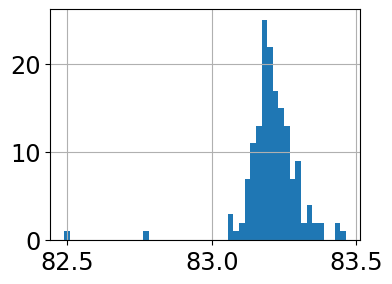

In [49]:
df_y["dpix"].hist(bins=50) 

## Distance in time between the pairs

In [50]:
df_y["dt"] = (df_y['expMidptMJD_x'] - df_y['expMidptMJD_y'])*3600*24

<Axes: >

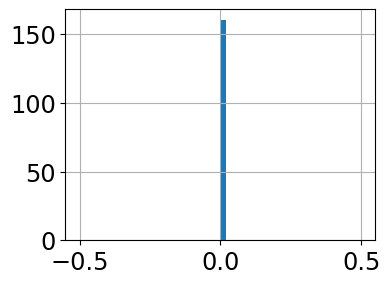

In [51]:
df_y["dt"].hist(bins=50)

In [52]:
# convert timedelta into seconds
# thus it confirms the exposure is the same
df_y["dTime"] = pd.to_timedelta(df_y['Time_x'] - df_y['Time_y']).dt.seconds

<Axes: >

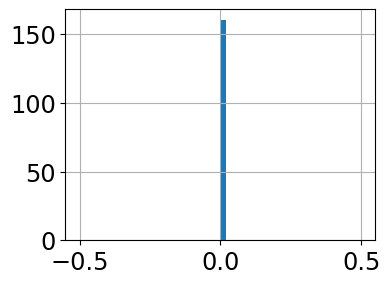

In [53]:
df_y["dTime"].hist(bins=50)

## Rename quantities supposed to be the same as same visit

In [54]:
df_y["band"] = df_y["band_x"]
df_z["band"] = df_z["band_x"]
df_g["band"] = df_g["band_x"]
df_r["band"] = df_r["band_x"]

df_y["Time"] = df_y["Time_x"]
df_z["Time"] = df_z["Time_x"]
df_g["Time"] = df_g["Time_x"]
df_r["Time"] = df_r["Time_x"]

df_y["nightObs"] = df_y["nightObs_x"]
df_z["nightObs"] = df_z["nightObs_x"]
df_g["nightObs"] = df_g["nightObs_x"]
df_r["nightObs"] = df_r["nightObs_x"]

#df_y["visit"] = df_y["visit_x"]
#df_z["visit"] = df_z["visit_x"]
#df_g["visit"] = df_g["visit_x"]
#df_r["visit"] = df_r["visit_x"]

df_y["expMidptMJD"] = df_y["expMidptMJD_x"]
df_z["expMidptMJD"] = df_z["expMidptMJD_x"]
df_g["expMidptMJD"] = df_g["expMidptMJD_x"]
df_r["expMidptMJD"] = df_r["expMidptMJD_x"]

## Difference in magnitudes between the pairs

#### psf Magnitude

In [55]:
df_y["dpsfMag"] = df_y["psfMag_x"] -  df_y["psfMag_y"]
df_z["dpsfMag"] = df_z["psfMag_x"] -  df_z["psfMag_y"]
df_g["dpsfMag"] = df_g["psfMag_x"] -  df_g["psfMag_y"]
df_r["dpsfMag"] = df_r["psfMag_x"] -  df_r["psfMag_y"]

In [56]:
df_y["dpsfInstMag"] = df_y["psfInstMag_x"] -  df_y["psfInstMag_y"]
df_z["dpsfInstMag"] = df_z["psfInstMag_x"] -  df_z["psfInstMag_y"]
df_g["dpsfInstMag"] = df_g["psfInstMag_x"] -  df_g["psfInstMag_y"]
df_r["dpsfInstMag"] = df_r["psfInstMag_x"] -  df_r["psfInstMag_y"]

In [57]:
df_y["dpsfMagErr"] = np.sqrt(df_y["psfMagErr_x"]**2 +  df_y["psfMagErr_y"]**2) 
df_z["dpsfMagErr"] = np.sqrt(df_z["psfMagErr_x"]**2 +  df_z["psfMagErr_y"]**2) 
df_g["dpsfMagErr"] = np.sqrt(df_g["psfMagErr_x"]**2 +  df_g["psfMagErr_y"]**2) 
df_r["dpsfMagErr"] = np.sqrt(df_r["psfMagErr_x"]**2 +  df_r["psfMagErr_y"]**2) 

In [58]:
df_y["dpsfInstMagErr"] = np.sqrt(df_y["psfInstMagErr_x"]**2 +  df_y["psfInstMagErr_y"]**2) 
df_z["dpsfInstMagErr"] = np.sqrt(df_z["psfInstMagErr_x"]**2 +  df_z["psfInstMagErr_y"]**2) 
df_g["dpsfInstMagErr"] = np.sqrt(df_g["psfInstMagErr_x"]**2 +  df_g["psfInstMagErr_y"]**2) 
df_r["dpsfInstMagErr"] = np.sqrt(df_r["psfInstMagErr_x"]**2 +  df_r["psfInstMagErr_y"]**2) 

#### Aperture Magnitude

In [59]:
df_y["dapFlux_35_0_calMag"] = df_y["apFlux_35_0_calMag_x"] - df_y["apFlux_35_0_calMag_y"]
df_z["dapFlux_35_0_calMag"] = df_z["apFlux_35_0_calMag_x"] - df_z["apFlux_35_0_calMag_y"]
df_g["dapFlux_35_0_calMag"] = df_g["apFlux_35_0_calMag_x"] - df_g["apFlux_35_0_calMag_y"]
df_r["dapFlux_35_0_calMag"] = df_r["apFlux_35_0_calMag_x"] - df_r["apFlux_35_0_calMag_y"]

In [60]:
df_y["dapFlux_35_0_calMagErr"] = np.sqrt(df_y["apFlux_35_0_calMagErr_x"]**2 + df_y["apFlux_35_0_calMagErr_y"]**2)
df_z["dapFlux_35_0_calMagErr"] = np.sqrt(df_z["apFlux_35_0_calMagErr_x"]**2 + df_z["apFlux_35_0_calMagErr_y"]**2)
df_g["dapFlux_35_0_calMagErr"] = np.sqrt(df_g["apFlux_35_0_calMagErr_x"]**2 + df_g["apFlux_35_0_calMagErr_y"]**2)
df_r["dapFlux_35_0_calMagErr"] = np.sqrt(df_r["apFlux_35_0_calMagErr_x"]**2 + df_r["apFlux_35_0_calMagErr_y"]**2)

In [61]:
df_y["dapFlux_50_0_calMag"] = df_y["apFlux_50_0_calMag_x"] - df_y["apFlux_50_0_calMag_y"]
df_z["dapFlux_50_0_calMag"] = df_z["apFlux_50_0_calMag_x"] - df_z["apFlux_50_0_calMag_y"]
df_g["dapFlux_50_0_calMag"] = df_g["apFlux_50_0_calMag_x"] - df_g["apFlux_50_0_calMag_y"]
df_r["dapFlux_50_0_calMag"] = df_r["apFlux_50_0_calMag_x"] - df_r["apFlux_50_0_calMag_y"]

In [62]:
df_y["dapFlux_50_0_calMagErr"] = np.sqrt(df_y["apFlux_50_0_calMagErr_x"]**2 + df_y["apFlux_50_0_calMagErr_y"]**2)
df_z["dapFlux_50_0_calMagErr"] = np.sqrt(df_z["apFlux_50_0_calMagErr_x"]**2 + df_z["apFlux_50_0_calMagErr_y"]**2)
df_g["dapFlux_50_0_calMagErr"] = np.sqrt(df_g["apFlux_50_0_calMagErr_x"]**2 + df_g["apFlux_50_0_calMagErr_y"]**2)
df_r["dapFlux_50_0_calMagErr"] = np.sqrt(df_r["apFlux_50_0_calMagErr_x"]**2 + df_r["apFlux_50_0_calMagErr_y"]**2)

### Relative magnitude difference

In [63]:
df_y["d_psfMag"] = df_y["dpsfMag"] - df_y["dpsfMag"].mean()
df_z["d_psfMag"] = df_z["dpsfMag"] - df_z["dpsfMag"].mean()
df_g["d_psfMag"] = df_g["dpsfMag"] - df_g["dpsfMag"].mean()
df_r["d_psfMag"] = df_r["dpsfMag"] - df_r["dpsfMag"].mean()

In [64]:
df_y["d_psfInstMag"] = df_y["dpsfInstMag"] - df_y["dpsfInstMag"].mean()
df_z["d_psfInstMag"] = df_z["dpsfInstMag"] - df_z["dpsfInstMag"].mean()
df_g["d_psfInstMag"] = df_g["dpsfInstMag"] - df_g["dpsfInstMag"].mean()
df_r["d_psfInstMag"] = df_r["dpsfInstMag"] - df_r["dpsfInstMag"].mean()

In [65]:
df_y["d_apFlux_35_0_calMag"] = df_y["dapFlux_35_0_calMag"] - df_y["dapFlux_35_0_calMag"].mean()
df_z["d_apFlux_35_0_calMag"] = df_z["dapFlux_35_0_calMag"] - df_z["dapFlux_35_0_calMag"].mean()
df_g["d_apFlux_35_0_calMag"] = df_g["dapFlux_35_0_calMag"] - df_g["dapFlux_35_0_calMag"].mean()
df_r["d_apFlux_35_0_calMag"] = df_r["dapFlux_35_0_calMag"] - df_r["dapFlux_35_0_calMag"].mean()

In [66]:
df_y["d_apFlux_50_0_calMag"] = df_y["dapFlux_50_0_calMag"] - df_y["dapFlux_50_0_calMag"].mean()
df_z["d_apFlux_50_0_calMag"] = df_z["dapFlux_50_0_calMag"] - df_z["dapFlux_50_0_calMag"].mean()
df_g["d_apFlux_50_0_calMag"] = df_g["dapFlux_50_0_calMag"] - df_g["dapFlux_50_0_calMag"].mean()
df_r["d_apFlux_50_0_calMag"] = df_r["dapFlux_50_0_calMag"] - df_r["dapFlux_50_0_calMag"].mean()

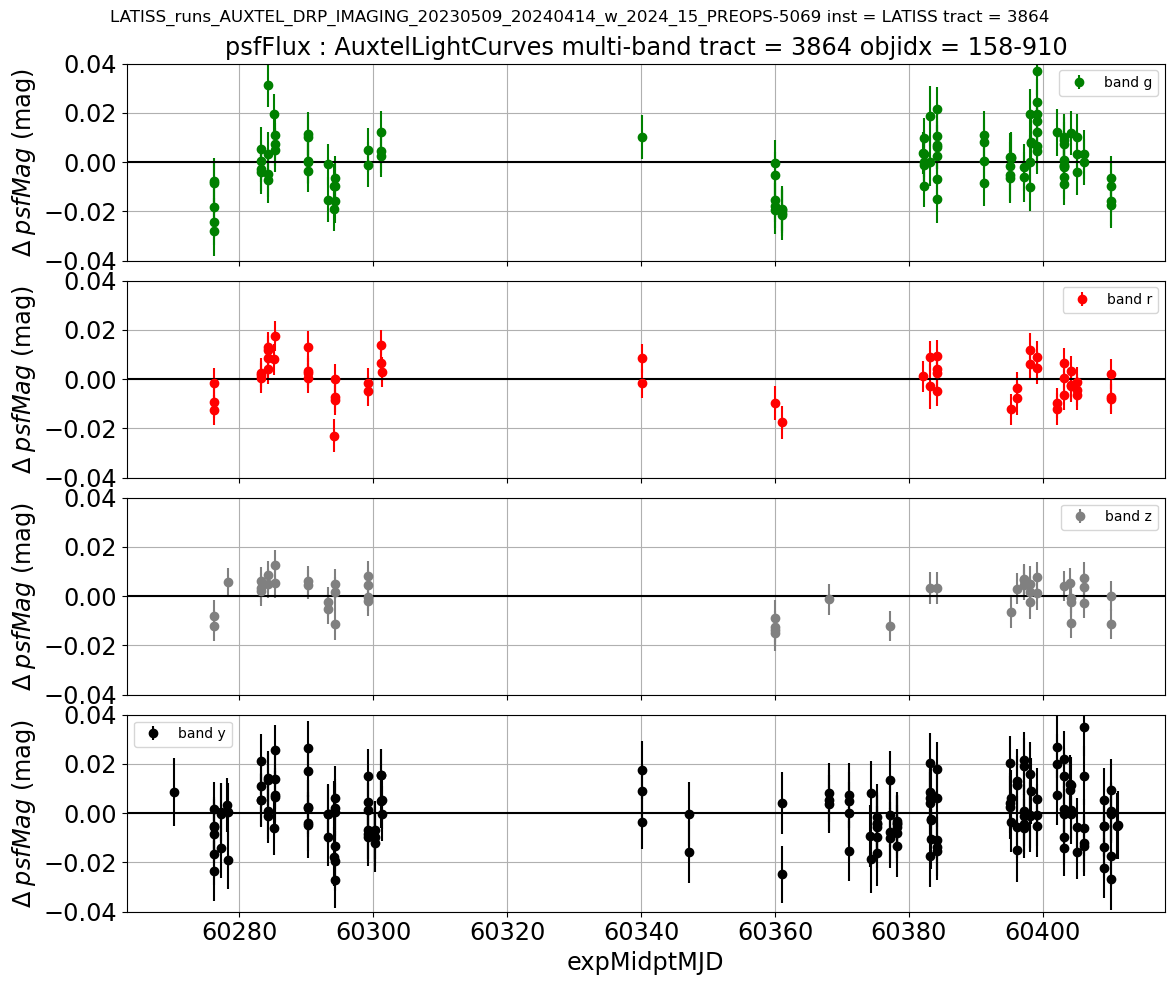

In [67]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,10),sharex=True,sharey=True)
title = f"psfFlux : AuxtelLightCurves multi-band tract = {tract} objidx = {objectname1}-{objectname2}"
ax1.errorbar(df_g.expMidptMJD,df_g.d_psfMag,yerr=df_g.dpsfMagErr,fmt="o",color="g",label="band g")
ax1.set_title(title)
ax2.errorbar(df_r.expMidptMJD,df_r.d_psfMag,yerr=df_r.dpsfMagErr,fmt="o",color="r",label="band r")
ax3.errorbar(df_z.expMidptMJD,df_z.d_psfMag,yerr=df_z.dpsfMagErr,fmt="o",color="grey",label="band z")
ax4.errorbar(df_y.expMidptMJD,df_y.d_psfMag,yerr=df_y.dpsfMagErr,fmt="o",color="k",label="band y")
#df_r.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax2,s=20,c="zeroPoint_x",cmap="jet",label="band r",grid=True,rot=45)
#df_z.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax3,s=20,c="zeroPoint_x",cmap="jet",label="band z",grid=True,rot=45)
#df_y.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax4,s=20,c="zeroPoint_x",cmap="jet",label="band y",grid=True,rot=45)
#plt.setp(ax1.get_xticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels(), visible=False)
#plt.setp(ax3.get_xticklabels(), visible=False)
#plt.setp(ax4.get_xticklabels(), visible=True)
#ax4.tick_params(labelbottom=True)
ax1.set_ylim(-0.04,0.04)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax4.set_xlabel("expMidptMJD")
ax1.set_ylabel("$\Delta \; psfMag$ (mag)")
ax2.set_ylabel("$\Delta \; psfMag$ (mag)")
ax3.set_ylabel("$\Delta \; psfMag$ (mag)")
ax4.set_ylabel("$\Delta \; psfMag$ (mag)")
ax1.axhline(0,color="k")
ax2.axhline(0,color="k")
ax3.axhline(0,color="k")
ax4.axhline(0,color="k")
plt.suptitle(suptitle)
plt.tight_layout()
plt.show()

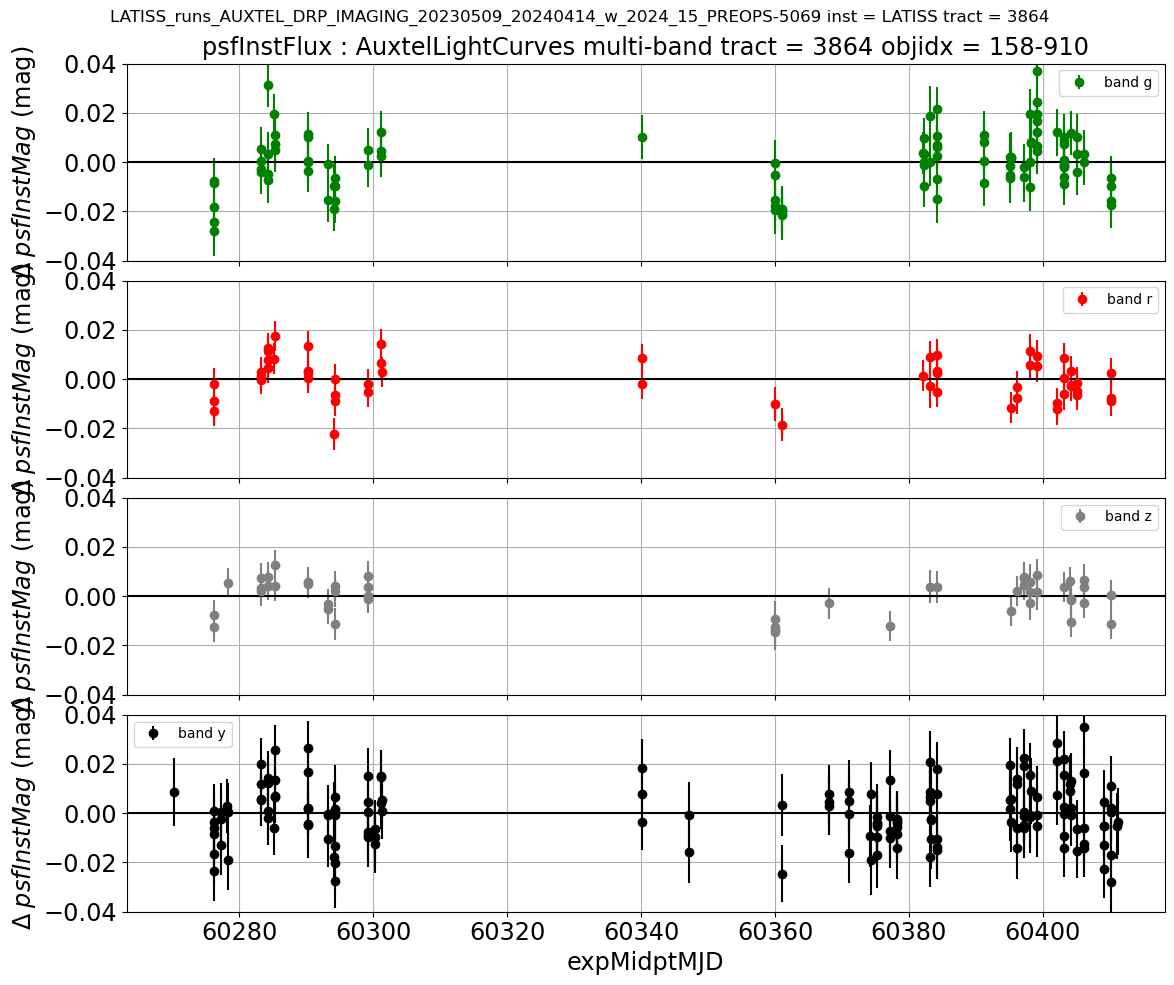

In [68]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,10),sharex=True,sharey=True)
title = f"psfInstFlux : AuxtelLightCurves multi-band tract = {tract} objidx = {objectname1}-{objectname2}"
ax1.errorbar(df_g.expMidptMJD,df_g.d_psfMag,yerr=df_g.dpsfMagErr,fmt="o",color="g",label="band g")
ax1.set_title(title)
ax2.errorbar(df_r.expMidptMJD,df_r.d_psfInstMag,yerr=df_r.dpsfMagErr,fmt="o",color="r",label="band r")
ax3.errorbar(df_z.expMidptMJD,df_z.d_psfInstMag,yerr=df_z.dpsfMagErr,fmt="o",color="grey",label="band z")
ax4.errorbar(df_y.expMidptMJD,df_y.d_psfInstMag,yerr=df_y.dpsfMagErr,fmt="o",color="k",label="band y")
#df_r.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax2,s=20,c="zeroPoint_x",cmap="jet",label="band r",grid=True,rot=45)
#df_z.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax3,s=20,c="zeroPoint_x",cmap="jet",label="band z",grid=True,rot=45)
#df_y.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax4,s=20,c="zeroPoint_x",cmap="jet",label="band y",grid=True,rot=45)
#plt.setp(ax1.get_xticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels(), visible=False)
#plt.setp(ax3.get_xticklabels(), visible=False)
#plt.setp(ax4.get_xticklabels(), visible=True)
#ax4.tick_params(labelbottom=True)
ax1.set_ylim(-0.04,0.04)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax4.set_xlabel("expMidptMJD")
ax1.set_ylabel("$\Delta \; psfInstMag$ (mag)")
ax2.set_ylabel("$\Delta \; psfInstMag$ (mag)")
ax3.set_ylabel("$\Delta \; psfInstMag$ (mag)")
ax4.set_ylabel("$\Delta \; psfInstMag$ (mag)")
ax1.axhline(0,color="k")
ax2.axhline(0,color="k")
ax3.axhline(0,color="k")
ax4.axhline(0,color="k")
plt.suptitle(suptitle)
plt.tight_layout()
plt.show()

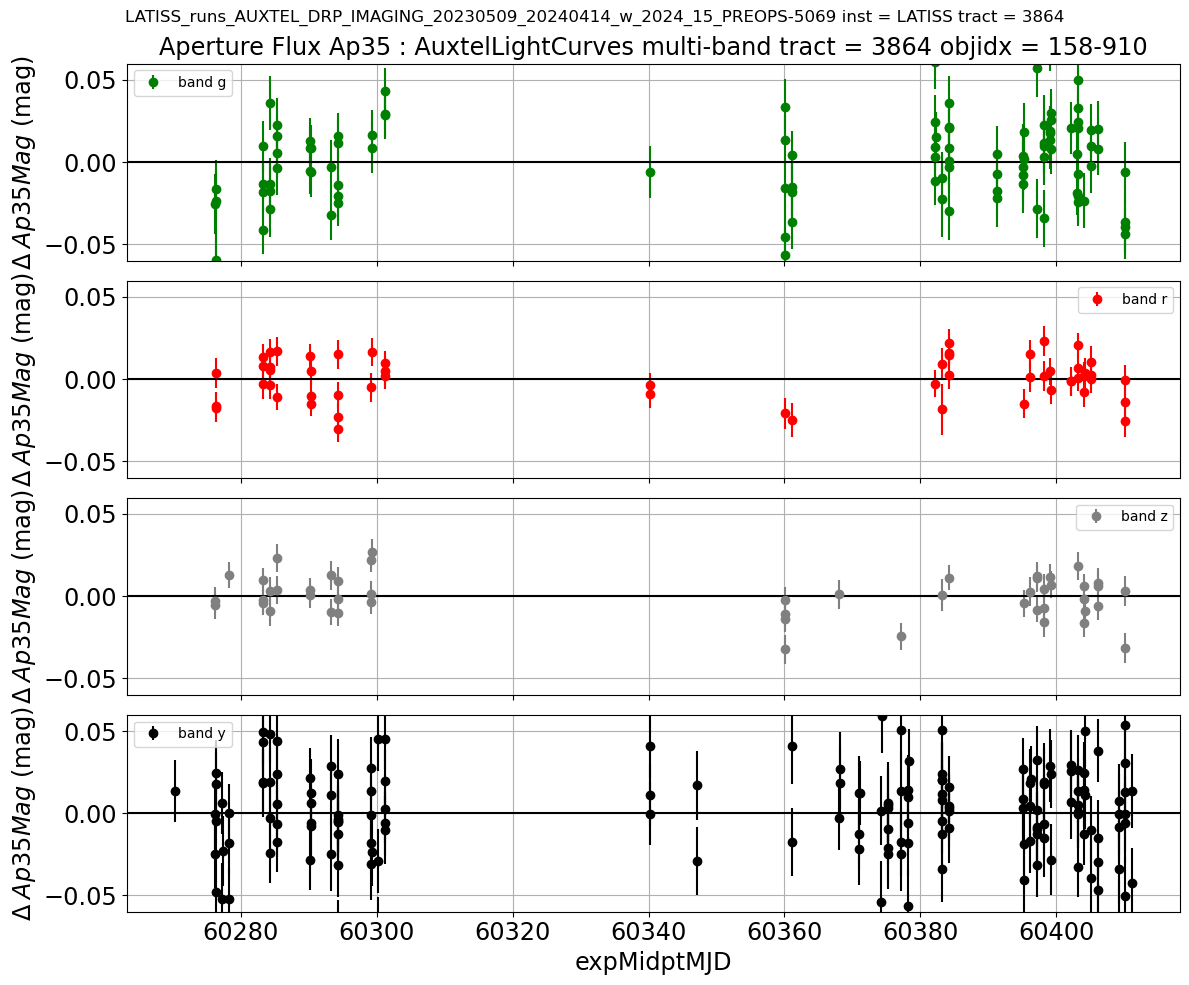

In [69]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,10),sharex=True,sharey=True)
title = f"Aperture Flux Ap35 : AuxtelLightCurves multi-band tract = {tract} objidx = {objectname1}-{objectname2}"
ax1.errorbar(df_g.expMidptMJD,df_g.d_apFlux_35_0_calMag,yerr=df_g.dapFlux_35_0_calMagErr,fmt="o",color="g",label="band g")
ax1.set_title(title)
ax2.errorbar(df_r.expMidptMJD,df_r.d_apFlux_35_0_calMag,yerr=df_r.dapFlux_35_0_calMagErr,fmt="o",color="r",label="band r")
ax3.errorbar(df_z.expMidptMJD,df_z.d_apFlux_35_0_calMag,yerr=df_z.dapFlux_35_0_calMagErr,fmt="o",color="grey",label="band z")
ax4.errorbar(df_y.expMidptMJD,df_y.d_apFlux_35_0_calMag,yerr=df_y.dapFlux_35_0_calMagErr,fmt="o",color="k",label="band y")
#df_r.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax2,s=20,c="zeroPoint_x",cmap="jet",label="band r",grid=True,rot=45)
#df_z.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax3,s=20,c="zeroPoint_x",cmap="jet",label="band z",grid=True,rot=45)
#df_y.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax4,s=20,c="zeroPoint_x",cmap="jet",label="band y",grid=True,rot=45)
#plt.setp(ax1.get_xticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels(), visible=False)
#plt.setp(ax3.get_xticklabels(), visible=False)
#plt.setp(ax4.get_xticklabels(), visible=True)
#ax4.tick_params(labelbottom=True)
ax1.set_ylim(-0.06,0.06)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax1.axhline(0,color="k")
ax2.axhline(0,color="k")
ax3.axhline(0,color="k")
ax4.axhline(0,color="k")
ax4.set_xlabel("expMidptMJD")
ax1.set_ylabel("$\Delta \; Ap35 Mag$ (mag)")
ax2.set_ylabel("$\Delta \; Ap35 Mag$ (mag)")
ax3.set_ylabel("$\Delta \; Ap35 Mag$ (mag)")
ax4.set_ylabel("$\Delta \; Ap35 Mag$ (mag)")
plt.suptitle(suptitle)
plt.tight_layout()
plt.show()

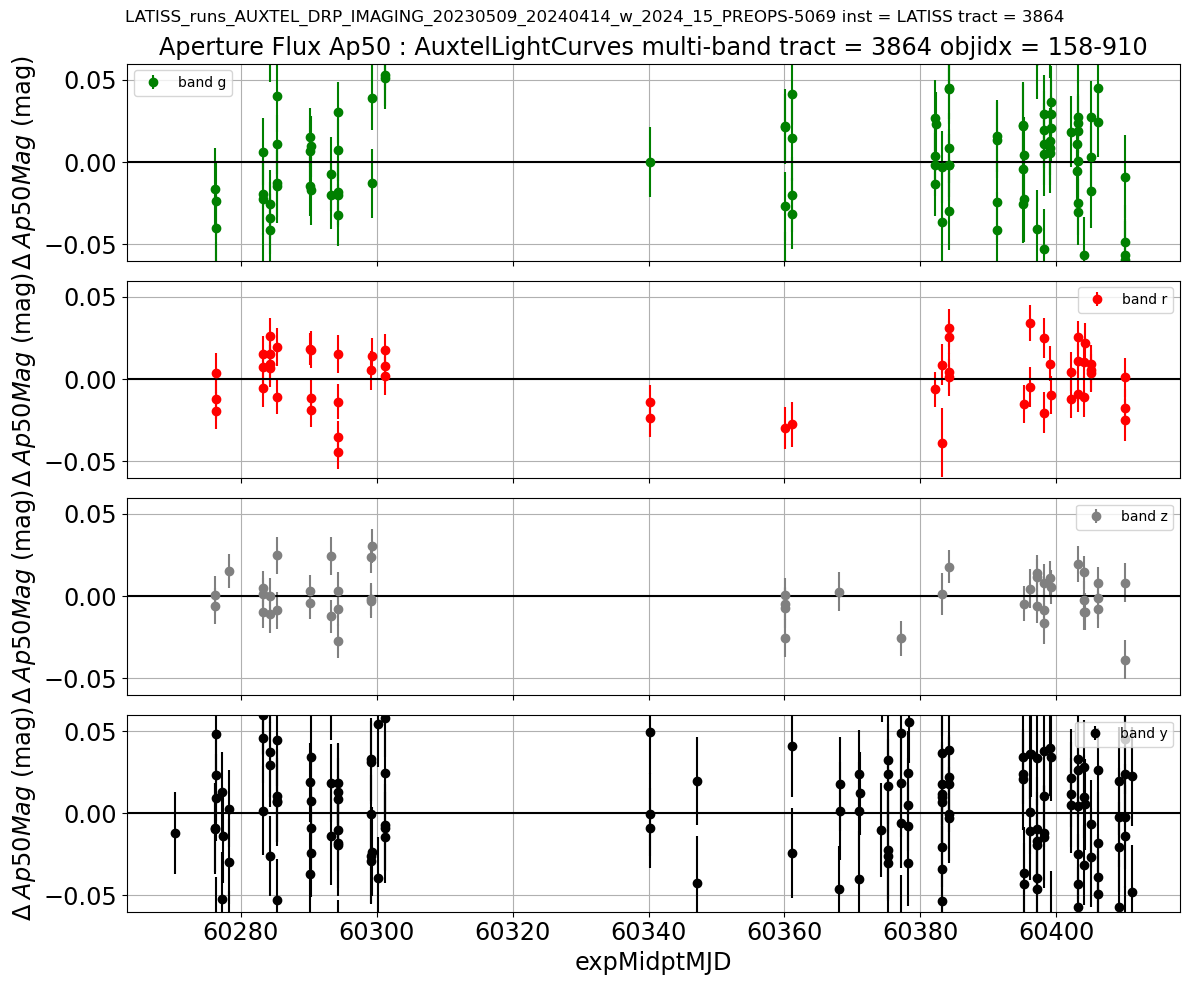

In [70]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,10),sharex=True,sharey=True)
title = f"Aperture Flux Ap50 : AuxtelLightCurves multi-band tract = {tract} objidx = {objectname1}-{objectname2}"
ax1.errorbar(df_g.expMidptMJD,df_g.d_apFlux_50_0_calMag,yerr=df_g.dapFlux_50_0_calMagErr,fmt="o",color="g",label="band g")
ax1.set_title(title)
ax2.errorbar(df_r.expMidptMJD,df_r.d_apFlux_50_0_calMag,yerr=df_r.dapFlux_50_0_calMagErr,fmt="o",color="r",label="band r")
ax3.errorbar(df_z.expMidptMJD,df_z.d_apFlux_50_0_calMag,yerr=df_z.dapFlux_50_0_calMagErr,fmt="o",color="grey",label="band z")
ax4.errorbar(df_y.expMidptMJD,df_y.d_apFlux_50_0_calMag,yerr=df_y.dapFlux_50_0_calMagErr,fmt="o",color="k",label="band y")
#df_r.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax2,s=20,c="zeroPoint_x",cmap="jet",label="band r",grid=True,rot=45)
#df_z.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax3,s=20,c="zeroPoint_x",cmap="jet",label="band z",grid=True,rot=45)
#df_y.plot.scatter(x="expMidptMJD",y="d_psfMag",ax=ax4,s=20,c="zeroPoint_x",cmap="jet",label="band y",grid=True,rot=45)
#plt.setp(ax1.get_xticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels(), visible=False)
#plt.setp(ax3.get_xticklabels(), visible=False)
#plt.setp(ax4.get_xticklabels(), visible=True)
#ax4.tick_params(labelbottom=True)
ax1.set_ylim(-0.06,0.06)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax4.set_xlabel("expMidptMJD")
ax1.set_ylabel("$\Delta \; Ap50 Mag$ (mag)")
ax2.set_ylabel("$\Delta \; Ap50 Mag$ (mag)")
ax3.set_ylabel("$\Delta \; Ap50 Mag$ (mag)")
ax4.set_ylabel("$\Delta \; Ap50 Mag$ (mag)")
ax1.axhline(0,color="k")
ax2.axhline(0,color="k")
ax3.axhline(0,color="k")
ax4.axhline(0,color="k")
plt.suptitle(suptitle)
plt.tight_layout()
plt.show()

## Neighbouring visits

In [71]:
groups_obs_size1 = df_myselectedvisits1.groupby(by=["nightObs","band"]).size()

In [72]:
groups_obs_size1

nightObs  band
20231115  g       6
          i       6
          r       2
20231120  g       4
          i       4
                 ..
20240409  z       6
20240410  g       3
          r       4
          y       5
          z       5
Length: 177, dtype: int64

In [73]:
df_groups_obs_size1 = groups_obs_size1.unstack()
df_groups_obs_size1

band,g,i,r,y,z
nightObs,,,,,
20231115,6.0,6.0,2.0,NaN,NaN
20231120,4.0,4.0,2.0,NaN,NaN
20231121,2.0,NaN,2.0,4.0,4.0
20231127,9.0,NaN,7.0,8.0,5.0
20231128,4.0,NaN,4.0,6.0,4.0
20231129,7.0,NaN,4.0,5.0,6.0
20231130,1.0,NaN,1.0,3.0,2.0
20231204,7.0,NaN,4.0,4.0,4.0
20231205,6.0,NaN,4.0,8.0,5.0


In [74]:
#groups_obs_visit = df_myselectedvisits.groupby(by=["nightObs","band","visit"]).mean()["psfMag"]
#groups_obs_visit 

In [75]:
groups_obs_visit1 = df_myselectedvisits1.groupby(by=["nightObs","band","visit"]).agg(time = ("Time","mean") ,psfMean = ("psfMag","mean"),apFlux_50_0_instFlux = ("apFlux_50_0_instFlux","mean"))
groups_obs_visit1 

time    psfMean  \
nightObs band visit                                                    
20231115 g    2023111500494 2023-11-16 07:24:27.061498112  15.432996   
              2023111500497 2023-11-16 07:27:28.094509056  15.375133   
              2023111500512 2023-11-16 07:42:58.140508928  15.411107   
              2023111500518 2023-11-16 07:49:11.978504960  15.417917   
              2023111500521 2023-11-16 07:52:18.278995968  15.404765   
...                                                   ...        ...   
20240410 z    2024041000472 2024-04-11 03:11:41.915499008  14.248749   
              2024041000476 2024-04-11 03:15:43.046493952  14.277826   
              2024041000484 2024-04-11 03:23:44.697007104  14.274794   
              2024041000488 2024-04-11 03:27:45.042008064  14.280765   
              2024041000492 2024-04-11 03:31:46.322509056  14.281770   

                             apFlux_50_0_instFlux  
nightObs band visit                                
20231115 g    2023111500494         117939.401479  
              2023111500497         117525.258889  
              2023111500512         121141.815515  
              2023111500518         118766.285667  
              2023111500521         120110.002569  
...                                           ...  
20240410 z    2024041000472         162895.359819  
              2024041000476         162029.088178  
              2024041000484         166422.277316  
              2024041000488         164254.006850  
              2024041000492         164438.820810  

[841 rows x 3 columns]

In [76]:
#groups_obs_visit.index

In [77]:
#groups_obs_visit.query('"nightObs" == 20231121  & "band" == "z"')

In [78]:
#groups_obs_visit.loc[(20231121,'z',2023112100516)] 

In [79]:
groups_obs_bandg_visit1 = df_myselectedvisits_g1.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandr_visit1 = df_myselectedvisits_r1.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandz_visit1 = df_myselectedvisits_z1.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandy_visit1 = df_myselectedvisits_y1.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))

In [80]:
groups_obs_bandg_visit2 = df_myselectedvisits_g2.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandr_visit2 = df_myselectedvisits_r2.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandz_visit2 = df_myselectedvisits_z2.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))
groups_obs_bandy_visit2 = df_myselectedvisits_y2.groupby(["nightObs","visit"]).agg(time = ("Time","mean"))

In [81]:
groups_obs_bandz_visit1.iloc[:5]

time
nightObs visit                                      
20231121 2023112100512 2023-11-22 07:07:19.090006016
         2023112100516 2023-11-22 07:11:12.433499904
         2023112100520 2023-11-22 07:15:09.515495936
         2023112100552 2023-11-22 07:46:17.304496128
20231127 2023112700291 2023-11-28 06:36:45.996996096

In [82]:
groups_obs_bandz_visit2.iloc[:5]

time
nightObs visit                                      
20231127 2023112700303 2023-11-28 06:48:13.984508928
         2023112700311 2023-11-28 06:56:06.837505024
         2023112700339 2023-11-28 07:18:44.018998016
         2023112700343 2023-11-28 07:22:36.430510080
         2023112700347 2023-11-28 07:26:27.344005888

## Process night-per night, band by band

We want to associate pairs of observation in different bands:

- visits in g with visits in r,z,y
- visits in r with visits in z,y
- visits in z with visits in y

In [83]:
def closestvisit(df1,df2):
    """
    This function associate pairs of closest observation

    input : the 2 dataframes (first to one for which one want to find the closest obs in dtaframe 2)
    output : the dataframe of similar format as the first one having columns on nightobs , visit time, dt from second dataframe)
    """
    d1 =df1.copy(deep=True)
    d2 =df2.copy(deep=True)
    all_samples = []
    df = pd.DataFrame(index=d1.index,columns=["nightObs2","visit2","time2","deltat"])
    for key in d1.index:

        nightObs = key[0]
        time1 = d1.loc[key]["time"]
        d2["dt"] = np.abs(d2["time"]-time1)
        d2["Dt"] = d2["time"]-time1
        cut_sel = (d2["dt"] == d2["dt"].min()) #& (d2["nightObs"] == nightObs)
        sample = d2[cut_sel]
        #df.iloc[key] = [sample.index[0][0],sample.index[0][1],sample["time"].values[0],sample['dt'].values[0]]
        df.loc[key]["nightObs2"] = sample.index[0][0]
        df.loc[key]["visit2"] = sample.index[0][1]
        df.loc[key]["time2"] = sample["time"].values[0]
        df.loc[key]["deltat"] = pd.to_timedelta(sample["Dt"].values[0], unit="s").total_seconds()
        all_samples.append(sample)

    # select observations during the same night
    df_back = df.copy(deep=True)
    flag_sel = []
    for key in df_back.index:
        nightObs = key[0]
        nightObs2 = df_back.loc[key]["nightObs2"]
        flag_sel.append(nightObs == nightObs2)
    df = df[flag_sel]
    return df

### process band g and r

In [84]:
dfg_r = closestvisit(groups_obs_bandg_visit1,groups_obs_bandr_visit2)
#dfg_r.drop(labels="deltat", axis=1,inplace=True)
dfg_r.columns = ["nightObs_r","visit_r","time_r","dtsec_r"]
dfg_r.dropna(axis=1,how="any",inplace=True)

In [85]:
dfg_r

nightObs_r        visit_r  \
nightObs visit                                     
20231115 2023111500494   20231115  2023111500525   
         2023111500497   20231115  2023111500525   
         2023111500512   20231115  2023111500525   
         2023111500518   20231115  2023111500525   
         2023111500521   20231115  2023111500525   
...                           ...            ...   
20240409 2024040900510   20240409  2024040900511   
         2024040900514   20240409  2024040900515   
         2024040900518   20240409  2024040900519   
         2024040900522   20240409  2024040900519   
         2024040900526   20240409  2024040900527   

                                               time_r      dtsec_r  
nightObs visit                                                      
20231115 2023111500494  2023-11-16T07:56:09.877006080  1902.815507  
         2023111500497  2023-11-16T07:56:09.877006080  1721.782497  
         2023111500512  2023-11-16T07:56:09.877006080   791.736497  
         2023111500518  2023-11-16T07:56:09.877006080   417.898501  
         2023111500521  2023-11-16T07:56:09.877006080    231.59801  
...                                               ...          ...  
20240409 2024040900510  2024-04-10T03:23:41.578007040    46.905507  
         2024040900514  2024-04-10T03:27:43.103506944    47.983503  
         2024040900518  2024-04-10T03:31:43.753502976    46.781005  
         2024040900522  2024-04-10T03:31:43.753502976  -193.598495  
         2024040900526  2024-04-10T03:39:45.300007936    46.874499  

[179 rows x 4 columns]

In [86]:
groups_obs_bandg_visit1.join(dfg_r)

time nightObs_r  \
nightObs visit                                                    
20231115 2023111500494 2023-11-16 07:24:27.061498112   20231115   
         2023111500497 2023-11-16 07:27:28.094509056   20231115   
         2023111500512 2023-11-16 07:42:58.140508928   20231115   
         2023111500518 2023-11-16 07:49:11.978504960   20231115   
         2023111500521 2023-11-16 07:52:18.278995968   20231115   
...                                              ...        ...   
20240409 2024040900522 2024-04-10 03:34:57.351997952   20240409   
         2024040900526 2024-04-10 03:38:58.425508096   20240409   
20240410 2024041000458 2024-04-11 02:58:23.175501056        NaN   
         2024041000482 2024-04-11 03:22:10.915505920        NaN   
         2024041000490 2024-04-11 03:30:12.763000064        NaN   

                              visit_r                         time_r  \
nightObs visit                                                         
20231115 2023111500494  2023111500525  2023-11-16T07:56:09.877006080   
         2023111500497  2023111500525  2023-11-16T07:56:09.877006080   
         2023111500512  2023111500525  2023-11-16T07:56:09.877006080   
         2023111500518  2023111500525  2023-11-16T07:56:09.877006080   
         2023111500521  2023111500525  2023-11-16T07:56:09.877006080   
...                               ...                            ...   
20240409 2024040900522  2024040900519  2024-04-10T03:31:43.753502976   
         2024040900526  2024040900527  2024-04-10T03:39:45.300007936   
20240410 2024041000458            NaN                            NaN   
         2024041000482            NaN                            NaN   
         2024041000490            NaN                            NaN   

                            dtsec_r  
nightObs visit                       
20231115 2023111500494  1902.815507  
         2023111500497  1721.782497  
         2023111500512   791.736497  
         2023111500518   417.898501  
         2023111500521    231.59801  
...                             ...  
20240409 2024040900522  -193.598495  
         2024040900526    46.874499  
20240410 2024041000458          NaN  
         2024041000482          NaN  
         2024041000490          NaN  

[244 rows x 5 columns]

### process band g and z

In [87]:
dfg_z = closestvisit(groups_obs_bandg_visit1,groups_obs_bandz_visit2)
#dfg_z.drop(labels="deltat", axis=1,inplace=True)
dfg_z.columns = ["nightObs_z","visit_z","time_z","dtsec_z"]
dfg_z.dropna(axis=1,how="any",inplace=True)

In [88]:
dfg_z.head(n=10)

nightObs_z        visit_z  \
nightObs visit                                     
20231127 2023112700297   20231127  2023112700303   
         2023112700301   20231127  2023112700303   
         2023112700305   20231127  2023112700303   
         2023112700309   20231127  2023112700311   
         2023112700341   20231127  2023112700343   
         2023112700345   20231127  2023112700347   
         2023112700353   20231127  2023112700355   
         2023112700357   20231127  2023112700359   
         2023112700393   20231127  2023112700359   
20231128 2023112800540   20231128  2023112800569   

                                               time_z      dtsec_z  
nightObs visit                                                      
20231127 2023112700297  2023-11-28T06:48:13.984508928   325.366507  
         2023112700301  2023-11-28T06:48:13.984508928    93.266508  
         2023112700305  2023-11-28T06:48:13.984508928  -142.937001  
         2023112700309  2023-11-28T06:56:06.837505024    93.070507  
         2023112700341  2023-11-28T07:22:36.430510080    93.526514  
         2023112700345  2023-11-28T07:26:27.344005888    93.504512  
         2023112700353  2023-11-28T07:34:07.270500096    93.456502  
         2023112700357  2023-11-28T07:37:57.146994944    93.374492  
         2023112700393  2023-11-28T07:37:57.146994944 -1957.223013  
20231128 2023112800540  2023-11-29T07:39:54.707991040  2101.502483

### process band g and y

In [89]:
dfg_y = closestvisit(groups_obs_bandg_visit1,groups_obs_bandy_visit2)
#dfg_y.drop(labels="deltat", axis=1,inplace=True)
dfg_y.columns = ["nightObs_y","visit_y","time_y","dtsec_y"]
dfg_y.dropna(axis=1,how="any",inplace=True)

In [90]:
dfg_y.head()

nightObs_y        visit_y  \
nightObs visit                                     
20231121 2023112100510   20231121  2023112100513   
         2023112100514   20231121  2023112100513   
20231127 2023112700297   20231127  2023112700296   
         2023112700301   20231127  2023112700304   
         2023112700305   20231127  2023112700304   

                                               time_y     dtsec_y  
nightObs visit                                                     
20231121 2023112100510  2023-11-22T07:08:07.767494912  141.822987  
         2023112100514  2023-11-22T07:08:07.767494912  -91.584507  
20231127 2023112700297  2023-11-28T06:41:22.040489984  -86.577512  
         2023112700301  2023-11-28T06:49:01.705502976  140.987502  
         2023112700305  2023-11-28T06:49:01.705502976  -95.216007

### Concatenation g with r,z,y

In [91]:
dfg_rzy = pd.concat([groups_obs_bandg_visit1,dfg_r,dfg_z,dfg_y],axis=1)

In [92]:
dfg_rzy.head() 

time nightObs_r  \
nightObs visit                                                    
20231115 2023111500494 2023-11-16 07:24:27.061498112   20231115   
         2023111500497 2023-11-16 07:27:28.094509056   20231115   
         2023111500512 2023-11-16 07:42:58.140508928   20231115   
         2023111500518 2023-11-16 07:49:11.978504960   20231115   
         2023111500521 2023-11-16 07:52:18.278995968   20231115   

                              visit_r                         time_r  \
nightObs visit                                                         
20231115 2023111500494  2023111500525  2023-11-16T07:56:09.877006080   
         2023111500497  2023111500525  2023-11-16T07:56:09.877006080   
         2023111500512  2023111500525  2023-11-16T07:56:09.877006080   
         2023111500518  2023111500525  2023-11-16T07:56:09.877006080   
         2023111500521  2023111500525  2023-11-16T07:56:09.877006080   

                            dtsec_r nightObs_z visit_z time_z dtsec_z  \
nightObs visit                                                          
20231115 2023111500494  1902.815507        NaN     NaN    NaN     NaN   
         2023111500497  1721.782497        NaN     NaN    NaN     NaN   
         2023111500512   791.736497        NaN     NaN    NaN     NaN   
         2023111500518   417.898501        NaN     NaN    NaN     NaN   
         2023111500521    231.59801        NaN     NaN    NaN     NaN   

                       nightObs_y visit_y time_y dtsec_y  
nightObs visit                                            
20231115 2023111500494        NaN     NaN    NaN     NaN  
         2023111500497        NaN     NaN    NaN     NaN  
         2023111500512        NaN     NaN    NaN     NaN  
         2023111500518        NaN     NaN    NaN     NaN  
         2023111500521        NaN     NaN    NaN     NaN

### process band r and z

In [93]:
dfr_z = closestvisit(groups_obs_bandr_visit1,groups_obs_bandz_visit2)
#dfr_z.drop(labels="deltat", axis=1,inplace=True)
dfr_z.columns = ["nightObs_z","visit_z","time_z","dtsec_z"]
dfr_z.dropna(axis=1,how="any",inplace=True)

In [94]:
dfr_z

nightObs_z        visit_z  \
nightObs visit                                     
20231127 2023112700302   20231127  2023112700303   
         2023112700306   20231127  2023112700303   
         2023112700310   20231127  2023112700311   
         2023112700338   20231127  2023112700339   
         2023112700346   20231127  2023112700347   
...                           ...            ...   
20240409 2024040900507   20240409  2024040900512   
         2024040900511   20240409  2024040900512   
         2024040900515   20240409  2024040900516   
         2024040900523   20240409  2024040900524   
         2024040900527   20240409  2024040900528   

                                               time_z     dtsec_z  
nightObs visit                                                     
20231127 2023112700302  2023-11-28T06:48:13.984508928   46.468017  
         2023112700306  2023-11-28T06:48:13.984508928 -189.753492  
         2023112700310  2023-11-28T06:56:06.837505024   46.517997  
         2023112700338  2023-11-28T07:18:44.018998016   46.842489  
         2023112700346  2023-11-28T07:26:27.344005888   46.728502  
...                                               ...         ...  
20240409 2024040900507  2024-04-10T03:24:28.521003008  289.784503  
         2024040900511  2024-04-10T03:24:28.521003008   46.942995  
         2024040900515  2024-04-10T03:28:29.952494080   46.848987  
         2024040900523  2024-04-10T03:36:31.170502912   46.885003  
         2024040900527  2024-04-10T03:40:32.221007104   46.920999  

[144 rows x 4 columns]

### process band r and y

In [95]:
dfr_y = closestvisit(groups_obs_bandr_visit1,groups_obs_bandy_visit2)
#dfr_y.drop(labels="deltat", axis=1,inplace=True)
dfr_y.columns = ["nightObs_y","visit_y","time_y","dtsec_y"]
dfr_y.dropna(axis=1,how="any",inplace=True)

In [96]:
dfr_y.head(n=10)

nightObs_y        visit_y  \
nightObs visit                                     
20231121 2023112100515   20231121  2023112100513   
         2023112100551   20231121  2023112100549   
20231127 2023112700302   20231127  2023112700304   
         2023112700306   20231127  2023112700308   
         2023112700310   20231127  2023112700312   
         2023112700338   20231127  2023112700340   
         2023112700346   20231127  2023112700348   
         2023112700354   20231127  2023112700356   
         2023112700358   20231127  2023112700360   
20231128 2023112800541   20231128  2023112800543   

                                               time_y     dtsec_y  
nightObs visit                                                     
20231121 2023112100515  2023-11-22T07:08:07.767494912 -138.141009  
         2023112100551  2023-11-22T07:43:14.763491072 -136.071513  
20231127 2023112700302  2023-11-28T06:49:01.705502976   94.189011  
         2023112700306  2023-11-28T06:52:59.095002112   95.357001  
         2023112700310  2023-11-28T06:56:55.432996096   95.113488  
         2023112700338  2023-11-28T07:19:31.999005952   94.822497  
         2023112700346  2023-11-28T07:27:15.565991936   94.950488  
         2023112700354  2023-11-28T07:34:55.209505024   94.676013  
         2023112700358  2023-11-28T07:38:45.680006912   95.296509  
20231128 2023112800541  2023-11-29T07:07:14.860506880    94.95601

### Concatenation of r with z,y

In [97]:
dfr_zy = pd.concat([groups_obs_bandr_visit1,dfr_z,dfr_y],axis=1)

In [98]:
dfr_zy.head()

time nightObs_z visit_z  \
nightObs visit                                                            
20231115 2023111500498 2023-11-16 07:28:14.769003008        NaN     NaN   
         2023111500522 2023-11-16 07:53:04.747996928        NaN     NaN   
20231120 2023112000320 2023-11-21 07:29:44.874492928        NaN     NaN   
         2023112000329 2023-11-21 07:39:03.734505984        NaN     NaN   
20231121 2023112100515 2023-11-22 07:10:25.908503040        NaN     NaN   

                       time_z dtsec_z nightObs_y        visit_y  \
nightObs visit                                                    
20231115 2023111500498    NaN     NaN        NaN            NaN   
         2023111500522    NaN     NaN        NaN            NaN   
20231120 2023112000320    NaN     NaN        NaN            NaN   
         2023112000329    NaN     NaN        NaN            NaN   
20231121 2023112100515    NaN     NaN   20231121  2023112100513   

                                               time_y     dtsec_y  
nightObs visit                                                     
20231115 2023111500498                            NaN         NaN  
         2023111500522                            NaN         NaN  
20231120 2023112000320                            NaN         NaN  
         2023112000329                            NaN         NaN  
20231121 2023112100515  2023-11-22T07:08:07.767494912 -138.141009

### process band z and y

In [99]:
dfz_y = closestvisit(groups_obs_bandz_visit1,groups_obs_bandy_visit2)
#dfz_y.drop(labels="deltat", axis=1,inplace=True)
dfz_y.columns = ["nightObs_y","visit_y","time_y","dtsec_y"]
dfz_y.dropna(axis=1,how="any",inplace=True)

In [100]:
dfz_y.head(n=10)

nightObs_y        visit_y  \
nightObs visit                                     
20231121 2023112100512   20231121  2023112100513   
         2023112100516   20231121  2023112100513   
         2023112100520   20231121  2023112100513   
         2023112100552   20231121  2023112100549   
20231127 2023112700291   20231127  2023112700296   
         2023112700299   20231127  2023112700296   
         2023112700303   20231127  2023112700304   
         2023112700307   20231127  2023112700308   
         2023112700311   20231127  2023112700312   
20231128 2023112800526   20231128  2023112800543   

                                               time_y     dtsec_y  
nightObs visit                                                     
20231121 2023112100512  2023-11-22T07:08:07.767494912   48.677488  
         2023112100516  2023-11-22T07:08:07.767494912 -184.666005  
         2023112100520  2023-11-22T07:08:07.767494912 -421.748002  
         2023112100552  2023-11-22T07:43:14.763491072 -182.541006  
20231127 2023112700291  2023-11-28T06:41:22.040489984  276.043493  
         2023112700299  2023-11-28T06:41:22.040489984 -179.504508  
         2023112700303  2023-11-28T06:49:01.705502976   47.720994  
         2023112700307  2023-11-28T06:52:59.095002112   48.537501  
         2023112700311  2023-11-28T06:56:55.432996096   48.595491  
20231128 2023112800526  2023-11-29T07:07:14.860506880  983.336013

### Concatenate z with y
-  (2023112100560,2023112100561) 	 	
-  (2023112700311,2023112700312) 

In [101]:
dfz_y = pd.concat([groups_obs_bandz_visit1,dfz_y],axis=1)

In [102]:
# select with the hour
dfz_y = dfz_y[np.abs(dfz_y.dtsec_y)<3600]
dfz_y.head(n=10)

time nightObs_y  \
nightObs visit                                                    
20231121 2023112100512 2023-11-22 07:07:19.090006016   20231121   
         2023112100516 2023-11-22 07:11:12.433499904   20231121   
         2023112100520 2023-11-22 07:15:09.515495936   20231121   
         2023112100552 2023-11-22 07:46:17.304496128   20231121   
20231127 2023112700291 2023-11-28 06:36:45.996996096   20231127   
         2023112700299 2023-11-28 06:44:21.544997120   20231127   
         2023112700303 2023-11-28 06:48:13.984508928   20231127   
         2023112700307 2023-11-28 06:52:10.557500928   20231127   
         2023112700311 2023-11-28 06:56:06.837505024   20231127   
20231128 2023112800526 2023-11-29 06:50:51.524493056   20231128   

                              visit_y                         time_y  \
nightObs visit                                                         
20231121 2023112100512  2023112100513  2023-11-22T07:08:07.767494912   
         2023112100516  2023112100513  2023-11-22T07:08:07.767494912   
         2023112100520  2023112100513  2023-11-22T07:08:07.767494912   
         2023112100552  2023112100549  2023-11-22T07:43:14.763491072   
20231127 2023112700291  2023112700296  2023-11-28T06:41:22.040489984   
         2023112700299  2023112700296  2023-11-28T06:41:22.040489984   
         2023112700303  2023112700304  2023-11-28T06:49:01.705502976   
         2023112700307  2023112700308  2023-11-28T06:52:59.095002112   
         2023112700311  2023112700312  2023-11-28T06:56:55.432996096   
20231128 2023112800526  2023112800543  2023-11-29T07:07:14.860506880   

                           dtsec_y  
nightObs visit                      
20231121 2023112100512   48.677488  
         2023112100516 -184.666005  
         2023112100520 -421.748002  
         2023112100552 -182.541006  
20231127 2023112700291  276.043493  
         2023112700299 -179.504508  
         2023112700303   47.720994  
         2023112700307   48.537501  
         2023112700311   48.595491  
20231128 2023112800526  983.336013

## Fetch a pair of  stars

In [103]:
def getcutoutandimage(visitId,df_selectedvisits):
    """
    visitId : the calexp where are the two stars
    df_selectedvisits : the list of all sources and visit of the main targeted star
    """

    row_source = df_selectedvisits[df_selectedvisits.visit == visitId].iloc[0]  
    band = row_source['band']

    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    calexp = butler.get('calexp', **dataId,collections=collections)   
    src_cat = butler.get('sourceTable',**dataId, collections=collections)

    #select on star
    #src_cat = src_cat[(src_cat["extendedness"]==0) & (src_cat["parentSourceId"] == 0) ]
    #src_cat = src_cat[src_cat["extendedness"]==0 ]


 
    x1 = row_source['x_x']
    y1 = row_source['y_x']
    ra1= row_source['ra_x']
    dec1= row_source['dec_x']
    psfMag1  = row_source['psfMag_x']  
    psfSigma1 = row_source['psfSigma_x']
    psfMagDiffMmag1 = row_source['psfMagDiffMmag_x'] 
    apFlux_50_0_instFlux1 = row_source['apFlux_50_0_instFlux_x']
    apFlux_50_0_instFluxErr1 = row_source['apFlux_50_0_instFluxErr_x']



    x2 = row_source['x_y']
    y2 = row_source['y_y']
    ra2= row_source['ra_y']
    dec2= row_source['dec_y']
    psfMag2  = row_source['psfMag_y']  
    psfSigma2 = row_source['psfSigma_y']
    psfMagDiffMmag2 = row_source['psfMagDiffMmag_y'] 
    apFlux_50_0_instFlux2 = row_source['apFlux_50_0_instFlux_y']
    apFlux_50_0_instFluxErr2 = row_source['apFlux_50_0_instFluxErr_y']

    
    # searcch the neighbouring stars
    #separation = find_neighbourg(ra_target,dec_target,src_cat)
    #src_cat["sep"] = separation


    spherePointCenter = lsst.geom.SpherePoint(ra1*lsst.geom.degrees, dec1*lsst.geom.degrees)
    spt = lsst.geom.SpherePoint(ra2*lsst.geom.degrees, dec2*lsst.geom.degrees)
    ang = spherePointCenter.separation(spt)
    ang_arcsec = ang.asArcseconds()
    
   
    x0 = (x1+x2)/2.
    y0 = (y1+y2)/2.
    ra0 = (ra1+ra2)/2.
    dec0 = (dec1+dec2)/2.
    

    dx1 = x1-x0
    dy1 = y1-y0
    dx2 = x2-x0
    dy2 = y2-y0
    
    
    boxSize = int(max(np.abs(x1-x2),np.abs(y1-y2)))
    xmin= x0-boxSize
    xmax= x0+boxSize
    ymin= y0-boxSize
    ymax= y0+boxSize
        
    
    minBbox = geom.Point2I(int(x0) - boxSize ,int(y0) - boxSize)
    maxBbox = geom.Point2I(int(x0) + boxSize, int(y0) + boxSize)
    
    srcBbox = geom.Box2I(minBbox, maxBbox)


    row_source['x0'] = x0
    row_source['y0'] = y0
    row_source['xmin'] = xmin
    row_source['ymin'] = ymin
    row_source['xmax'] = xmax
    row_source['ymax'] = ymax
    row_source['ra0'] = ra0
    row_source['dec0'] = dec0

    row_source['x1'] = x1
    row_source['y1'] = y1
    row_source['dx1'] = dx1
    row_source['dy1'] = dy1
    row_source['ra1'] = ra1
    row_source['dec1'] = dec1

    row_source['x2'] = x2
    row_source['y2'] = y2
    row_source['dx2'] = dx2
    row_source['dy2'] = dy2
    row_source['ra2'] = ra2
    row_source['dec2'] = dec2
    
    
    # Make the cutout
    try:
        subimg = afwImage.ExposureF(calexp, srcBbox, afwImage.PARENT, True)
        #subimg2 = calexp.getImage().array[int(ySrc) - boxSize: int(ySrc) + boxSize+1, int(xSrc) - boxSize:int(xSrc) + boxSize+1 ]
        #subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)
        #all_cutout.append(subimgRgb)
        cutout=subimg.image.array
        
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)     
        cutout = None

    df_pair = row_source.to_frame()
    return row_source,cutout



In [104]:
def plotfullcalexp(row_pair,ax=None):
    """
    """
    flag_ax = False
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(10,10))
    else:
        flag_ax = True

    band = 0
    ra = 0
    dec = 0

    x0 = row_pair["x0"]
    y0 = row_pair["y0"]
    
    visitId = row_pair["visit"]
    band = row_pair["band"]
    psfMag1 = row_pair["psfMag_x"]
    psfSigma1 = row_pair["psfSigma_x"]
    x1 = row_pair["x1"]
    y1 = row_pair["y1"]
    ra1 = row_pair['ra2']
    dec1 = row_pair['dec2']
    ann1 = Annulus((x1,y1),r=5*psfSigma1,width=0.1,color="r")
    ax.add_patch(ann1)

  
    psfMag2 = row_pair["psfMag_y"]
    psfSigma2 = row_pair["psfSigma_y"]
    x2 = row_pair["x2"]
    y2 = row_pair["y2"]
    ra2 = row_pair['ra2']
    dec2 = row_pair['dec2']
    ann2 = Annulus((x2,y2),r=5*psfSigma2,width=0.1,color="orange")
    ax.add_patch(ann2)

    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    calexp = butler.get('calexp', **dataId,collections=collections)
    imgarr = calexp.image.array 
    shape =  imgarr.shape
    #extent = [x0-shape[1]/2., x0+shape[1]/2., y0-shape[0]/2., y0+shape[0]/2.]
   
    z = ZScaleInterval()
    z1,z2 = z.get_limits(imgarr)
    im = ax.imshow(imgarr,origin="lower",cmap="grey",vmin=z1, vmax=z2)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad="1%")
    # useless with zscale
    plt.colorbar(im, cax=cax)

    
    title = f"calexp {visitId}, objidx:{objectname1},{objectname2} band :{band}"
    ax.set_title(title)
    ax.axvline(x0,color="w",linestyle=":")
    ax.axhline(y0,color="w",linestyle=":")
    

    textstr = '\n'.join((
    r'$exposure = %.0f$' % (visitId, ),
    r'$psfMag1 = %.02f mag$' %(psfMag1, ), 
    r'$psfMag2 = %.02f mag$' %(psfMag2, ),  
    r'$ra_1 = %f deg $' %(ra1,),
    r'$ra_2 = %f deg $' %(ra2,),  
    r'$dec_1 = %f deg $' %(dec1,),
    r'$dec_2 = %f deg $' %(dec2,)))  
  

    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="y", weight='bold',bbox=props) 
    #if flag_deblend_skipped:
    #    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="r", weight='bold',bbox=props) 
    #else:
    #    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="g", weight='bold',bbox=props) 

    if not flag_ax:
        plt.show()   

In [105]:
def plotcutout(row_pair,cutout,ax=None):
    """
    """
    flag_ax = False
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,5))
    else:
        flag_ax = True

    if cutout is None:
        print("No Cutout")
        return

    boxSize= cutout.shape[0]//2
    extent = [ row_pair['xmin'], row_pair['xmax'], row_pair['ymin'], row_pair['ymax']]
    
    z = ZScaleInterval()
    z1,z2 = z.get_limits(cutout)
    im = ax.imshow(cutout,origin='lower',cmap="grey",vmin=z1, vmax=z2,extent = extent)
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad="1%")
    # useless with zscale
    #plt.colorbar(im, cax=cax)

  

    band = 0
    ra = 0
    dec = 0
    
  
    visitId = row_pair["visit"]
    band = row_pair["band"]
    psfMag1 = row_pair["psfMag_x"]
    psfSigma1 = row_pair["psfSigma_x"]
    x1 = row_pair["x1"]
    y1 = row_pair["y1"]
    ra1 = row_pair['ra1']
    dec1 = row_pair['dec1']
    ann1 = Annulus((x1,y1),r=3*psfSigma1,width=0.1,color="r")
    ax.add_patch(ann1)

  
    psfMag2 = row_pair["psfMag_y"]
    psfSigma2 = row_pair["psfSigma_y"]
    x2 = row_pair["x2"]
    y2 = row_pair["y2"]
    
    ann2 = Annulus((x2,y2),r=3*psfSigma2,width=0.1,color="orange")
    ax.add_patch(ann2)
    
    #title = f"obj:{objectname}, b:{band}, (ra:{ra:.2f}, dec:{dec:.2f})"
    #ax.set_title(title)

    textstr = '\n'.join((
    r'$expos = %.0f$' % (visitId, ),
    r'$band  = %s $' % (band,),
    r'$psfMag1 = %.02f mag$' %(psfMag1, ), 
    r'$psfMag2 = %.02f mag$' %(psfMag2, ),  
    r'$\sigma_{PSF} = %.2f pix$' % (psfSigma1 , )))
   
 

    
    ax.text(0.05, 0.97, textstr, transform=ax.transAxes, fontsize=16,verticalalignment='top',color="orange", weight='bold',bbox=props) 


    
    if not flag_ax:
        plt.show()   

In [106]:
df_z.head(n=10)[["nightObs","visit"]]

,nightObs,visit
0,20231127,2023112700303
1,20231127,2023112700311
2,20231129,2023112900587
3,20231204,2023120400529
4,20231204,2023120400533
5,20231204,2023120400595
6,20231205,2023120500507
7,20231205,2023120500511
8,20231206,2023120600297
9,20231206,2023120600305


In [107]:
df_y.head(n=20)[["nightObs","visit"]]

,nightObs,visit
0,20231121,2023112100513
1,20231127,2023112700304
2,20231127,2023112700308
3,20231127,2023112700312
4,20231127,2023112700340
5,20231127,2023112700348
6,20231127,2023112700360
7,20231128,2023112800543
8,20231128,2023112800562
9,20231128,2023112800578


## Differential colors study (star 1 - star 2)

### Build color ratio in G and R band

### G and R band colors

In [108]:
dfg_r = dfg_rzy[["time","nightObs_r","visit_r","time_r","dtsec_r"]] 
dfg_r.head()

time nightObs_r  \
nightObs visit                                                    
20231115 2023111500494 2023-11-16 07:24:27.061498112   20231115   
         2023111500497 2023-11-16 07:27:28.094509056   20231115   
         2023111500512 2023-11-16 07:42:58.140508928   20231115   
         2023111500518 2023-11-16 07:49:11.978504960   20231115   
         2023111500521 2023-11-16 07:52:18.278995968   20231115   

                              visit_r                         time_r  \
nightObs visit                                                         
20231115 2023111500494  2023111500525  2023-11-16T07:56:09.877006080   
         2023111500497  2023111500525  2023-11-16T07:56:09.877006080   
         2023111500512  2023111500525  2023-11-16T07:56:09.877006080   
         2023111500518  2023111500525  2023-11-16T07:56:09.877006080   
         2023111500521  2023111500525  2023-11-16T07:56:09.877006080   

                            dtsec_r  
nightObs visit                       
20231115 2023111500494  1902.815507  
         2023111500497  1721.782497  
         2023111500512   791.736497  
         2023111500518   417.898501  
         2023111500521    231.59801

#### Select pairs in g,r within 1 minute

In [109]:
dfg_r_sel = dfg_r[np.abs(dfg_r["dtsec_r"])<60]
dfg_r_sel.head() 

time nightObs_r  \
nightObs visit                                                    
20231127 2023112700341 2023-11-28 07:21:02.903995904   20231127   
         2023112700345 2023-11-28 07:24:53.839493888   20231127   
         2023112700357 2023-11-28 07:36:23.772502016   20231127   
20231204 2023120400527 2023-12-05 06:23:33.953506048   20231204   
         2023120400585 2023-12-05 07:14:47.779991040   20231204   

                              visit_r                         time_r  \
nightObs visit                                                         
20231127 2023112700341  2023112700342  2023-11-28T07:21:49.638501888   
         2023112700345  2023112700346  2023-11-28T07:25:40.615503872   
         2023112700357  2023112700358  2023-11-28T07:37:10.383496960   
20231204 2023120400527  2023120400528  2023-12-05T06:24:20.648002048   
         2023120400585  2023120400586  2023-12-05T07:15:34.482998016   

                          dtsec_r  
nightObs visit                     
20231127 2023112700341  46.734505  
         2023112700345  46.776009  
         2023112700357  46.610994  
20231204 2023120400527  46.694496  
         2023120400585  46.703006

# Loop over band pairs exposures nearby in time to calculate colors and relative colors of two stars 

In [110]:
def GetFluxes2StarsTwoBands(band1,band2,dfb1_b2,df_selectedvisits_b1,df_selectedvisits_b2):
    """
    """
    df_col_b1b2 = pd.DataFrame(columns = ["band1","exposure1","time1","psfMag11","psfMag12",
                                          "psfMagErr11","psfMagErr12",
                                          "apMag11","apMag12","apMagErr11","apMagErr12",
                                          "band2","exposure2","time2","psfMag21","psfMag22",
                                          "psfMagErr21","psfMagErr22",
                                          "apMag21","apMag22","apMagErr21","apMagErr22",
                                          "dt"])
    entrycount = 0
    for idx,key in enumerate(dfb1_b2.index):
        print(idx,key)
        visit1 = key[1]
        visit2 = dfb1_b2.loc[key]["visit_" + band2]
        time1 = dfb1_b2.loc[key]["time"]
        time2 = dfb1_b2.loc[key]["time_" + band2]
        dt = dfb1_b2.loc[key]["dtsec_" + band2]
        print(f"======================= night :: {key[0]} ==> ({band1},{band2}) = ({visit1},{visit2}) =============================" )
        #row_target = df_selectedvisits_b1[df_selectedvisits_b1.visit == visit1].iloc[0]
        #print(row_target)
        # the selected sources retrieved from the sources associated to that calexp
        try:
            row_pair_b1,cutoutb1 = getcutoutandimage(visit1,df_selectedvisits_b1) 
            row_pair_b2,cutoutb2 = getcutoutandimage(visit2,df_selectedvisits_b2) 

            # first indec band, second index star
            # Star 1 in band 1
            psfMag11 =  row_pair_b1["psfMag_x"]
            psfMagErr11 =  row_pair_b1["psfMagErr_x"]
            apMag11 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_x"])
            apMagErr11 =  2.5/np.log(10)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_x"])
            
            # Star 2 in band 1
            psfMag12 =  row_pair_b1["psfMag_y"]
            psfMagErr12 =  row_pair_b1["psfMagErr_y"]
            apMag12 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_y"])
            apMagErr12 =  2.5/np.log(10)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_y"])
            
            # Star 1 in band 2
            psfMag21 =  row_pair_b2["psfMag_x"]
            psfMagErr21 =  row_pair_b2["psfMagErr_x"]
            apMag21 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_x"])
            apMagErr21 =  2.5/np.log(10)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_x"])
            
            # Star 2 in band 2
            psfMag22 =  row_pair_b2["psfMag_y"]
            psfMagErr22 =  row_pair_b2["psfMagErr_y"]
            apMag22 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_y"])
            apMagErr22 =  2.5/np.log(10)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_y"])



            
            df_col_b1b2.loc[entrycount] = [band1,visit1,time1,psfMag11,psfMag12,psfMagErr11,psfMagErr12,apMag11,apMag12,apMagErr11,apMagErr12,
                                           band2,visit2,time2,psfMag21,psfMag22,psfMagErr21,psfMagErr22,apMag21,apMag22,apMagErr21,apMagErr22,dt]
            entrycount+=1

        
        except Exception as inst:
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)
            continue
      

        if idx%10 == 0:
            if cutoutb1 is not None and cutoutb2 is not None:
                NROWS = 1
                NCOLS = 2
                fig, (ax1,ax2) = plt.subplots(ncols=NCOLS,nrows=NROWS,figsize=(6*NCOLS,6*NROWS))
                plotcutout(row_pair_b1,cutoutb1,ax=ax1)
                plotcutout(row_pair_b2,cutoutb2,ax=ax2)
                plt.show()

    # band 1 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag12"])
    df_col_b1b2["deltapsfmagErr_s12b1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr12"]**2)

    df_col_b1b2["deltaapmag_s12b1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag12"])
    df_col_b1b2["deltaapmagErr_s12b1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr12"]**2)
    
    # band 2 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b2"] = (df_col_b1b2["psfMag21"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["deltapsfmagErr_s12b2"] = np.sqrt(df_col_b1b2["psfMagErr21"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["deltaapmag_s12b2"] = (df_col_b1b2["apMag21"] - df_col_b1b2["apMag22"])
    df_col_b1b2["deltaapmagErr_s12b2"] = np.sqrt(df_col_b1b2["apMagErr21"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # Star 1 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag21"])
    df_col_b1b2["psfcol12Err_s1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr21"]**2)
    df_col_b1b2["apcol12_s1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag21"])
    df_col_b1b2["apcol12Err_s1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr21"]**2)

    
    # Star 2 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s2"] = (df_col_b1b2["psfMag12"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["psfcol12Err_s2"] = np.sqrt(df_col_b1b2["psfMagErr12"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["apcol12_s2"] = (df_col_b1b2["apMag12"] - df_col_b1b2["apMag22"])
    df_col_b1b2["apcol12Err_s2"] = np.sqrt(df_col_b1b2["apMagErr12"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # relative color star1 - star2
    df_col_b1b2["psfcol12_s12"] = df_col_b1b2["psfcol12_s1"] - df_col_b1b2["psfcol12_s2"]
    df_col_b1b2["psfcol12Err_s12"] = np.sqrt(df_col_b1b2["psfcol12Err_s1"]**2 + df_col_b1b2["psfcol12Err_s2"]**2)
    df_col_b1b2["apcol12_s12"] = df_col_b1b2["apcol12_s1"] - df_col_b1b2["apcol12_s2"]
    df_col_b1b2["apcol12Err_s12"] = np.sqrt(df_col_b1b2["apcol12Err_s1"]**2 + df_col_b1b2["apcol12Err_s2"]**2)
    
    return df_col_b1b2


In [111]:
df_g

,sourceId_x,psfFlux_x,psfFluxErr_x,psfFlux_flag_x,psfFlux_apCorr_x,psfFlux_apCorrErr_x,extendedness_x,detect_isPrimary_x,deblend_skipped_x,gaussianFlux_x,gaussianFluxErr_x,gaussianFlux_flag_x,localPhotoCalib_x,localPhotoCalibErr_x,localPhotoCalib_flag_x,index_x,visit,detector_x,ra_x,dec_x,physical_filter_x,band_x,apFlux_35_0_instFlux_x,apFlux_35_0_instFluxErr_x,x_x,y_x,apFlux_50_0_instFlux_x,apFlux_50_0_instFluxErr_x,apFlux_50_0_flag_x,localBackground_instFlux_x,localBackground_flag_x,source_row_x,obj_index_x,psfSn_x,psfMag_x,psfMagErr_x,apFlux_35_0_calFlux_x,apFlux_35_0_calFluxErr_x,apFlux_35_0_calMag_x,apFlux_35_0_calMagErr_x,apFlux_50_0_calFlux_x,apFlux_50_0_calFluxErr_x,apFlux_50_0_calMag_x,apFlux_50_0_calMagErr_x,psfInstMag_x,psfInstMagErr_x,psfGausFluxRatio_x,ccd_ccdVisitId_x,ccd_visitId_x,ccd_band_x,zenithDistance_x,zeroPoint_x,psfSigma_x,skyBg_x,skyNoise_x,astromOffsetMean_x,astromOffsetStd_x,nPsfStar_x,psfStarDeltaE1Median_x,psfStarDeltaE2Median_x,psfStarDeltaE1Scatter_x,psfStarDeltaE2Scatter_x,psfStarDeltaSizeMedian_x,psfStarDeltaSizeScatter_x,psfStarScaledDeltaSizeScatter_x,psfTraceRadiusDelta_x,maxDistToNearestPsf_x,effTime_x,effTimePsfSigmaScale_x,effTimeSkyBgScale_x,effTimeZeroPointScale_x,decl_x,ccd_detector_x,seeing_x,skyRotation_x,expMidpt_x,expMidptMJD_x,expTime_x,obsStart_x,obsStartMJD_x,darkTime_x,xSize_x,ySize_x,llcra_x,llcdec_x,ulcra_x,ulcdec_x,urcra_x,urcdec_x,lrcra_x,lrcdec_x,airmass_x,medianE_x,dra_x,ddec_x,psfMagDiffMmag_x,psfMagDiffChi_x,raDiffMas_x,decDiffMas_x,raCosDecDiffMas_x,localPhotoCalibMag_x,localPhotoCalibMagErr_x,DZP_x,nightObs_x,Time_x,sourceId_y,psfFlux_y,psfFluxErr_y,psfFlux_flag_y,psfFlux_apCorr_y,psfFlux_apCorrErr_y,extendedness_y,detect_isPrimary_y,deblend_skipped_y,gaussianFlux_y,gaussianFluxErr_y,gaussianFlux_flag_y,localPhotoCalib_y,localPhotoCalibErr_y,localPhotoCalib_flag_y,index_y,detector_y,ra_y,dec_y,physical_filter_y,band_y,apFlux_35_0_instFlux_y,apFlux_35_0_instFluxErr_y,x_y,y_y,apFlux_50_0_instFlux_y,apFlux_50_0_instFluxErr_y,apFlux_50_0_flag_y,localBackground_instFlux_y,localBackground_flag_y,source_row_y,obj_index_y,psfSn_y,psfMag_y,psfMagErr_y,apFlux_35_0_calFlux_y,apFlux_35_0_calFluxErr_y,apFlux_35_0_calMag_y,apFlux_35_0_calMagErr_y,apFlux_50_0_calFlux_y,apFlux_50_0_calFluxErr_y,apFlux_50_0_calMag_y,apFlux_50_0_calMagErr_y,psfInstMag_y,psfInstMagErr_y,psfGausFluxRatio_y,ccd_ccdVisitId_y,ccd_visitId_y,ccd_band_y,zenithDistance_y,zeroPoint_y,psfSigma_y,skyBg_y,skyNoise_y,astromOffsetMean_y,astromOffsetStd_y,nPsfStar_y,psfStarDeltaE1Median_y,psfStarDeltaE2Median_y,psfStarDeltaE1Scatter_y,psfStarDeltaE2Scatter_y,psfStarDeltaSizeMedian_y,psfStarDeltaSizeScatter_y,psfStarScaledDeltaSizeScatter_y,psfTraceRadiusDelta_y,maxDistToNearestPsf_y,effTime_y,effTimePsfSigmaScale_y,effTimeSkyBgScale_y,effTimeZeroPointScale_y,decl_y,ccd_detector_y,seeing_y,skyRotation_y,expMidpt_y,expMidptMJD_y,expTime_y,obsStart_y,obsStartMJD_y,darkTime_y,xSize_y,ySize_y,llcra_y,llcdec_y,ulcra_y,ulcdec_y,urcra_y,urcdec_y,lrcra_y,lrcdec_y,airmass_y,medianE_y,dra_y,ddec_y,psfMagDiffMmag_y,psfMagDiffChi_y,raDiffMas_y,decDiffMas_y,raCosDecDiffMas_y,localPhotoCalibMag_y,localPhotoCalibMagErr_y,DZP_y,nightObs_y,Time_y,band,Time,nightObs,expMidptMJD,dpsfMag,dpsfInstMag,dpsfMagErr,dpsfInstMagErr,dapFlux_35_0_calMag,dapFlux_35_0_calMagErr,dapFlux_50_0_calMag,dapFlux_50_0_calMagErr,d_psfMag,d_psfInstMag,d_apFlux_35_0_calMag,d_apFlux_50_0_calMag
0,178666564663378066,2.553677e+06,11970.666651,False,1.019035,0.0,0.0,True,False,2.521685e+06,13772.788723,False,21.427802,0.047845,False,145,2023112700301,0,122.513469,-36.199389,SDSSg_65mm~empty,g,118133.811709,776.026527,2013.339628,1727.465482,121029.914304,1061.431516,False,0.398151,False,145,158,213.327885,15.382085,0.005090,2.531348e+06,16628.542613,15.391620,0.007132,2.593405e+06,22744.144147,15.365324,0.009522,18.709529,0.005090,1.012687,42597428480,2023112700301,g,21.555965,28.074050,5.274516,40.245033,9.185352,0.011388,0.006632,68,-0.000269,0.002281,0.018297,0.

In [112]:
def GetFluxes2StarsTwoBandsNoCutout(band1,band2,dfb1_b2,df_selectedvisits_b1,df_selectedvisits_b2):
    """
    """
    #df_col_b1b2 = pd.DataFrame(columns = ["band1","exposure1","time1","psfMag11","psfMag12","band2","exposure2","time2","psfMag21","psfMag22","dt"])
    #df_col_b1b2 = pd.DataFrame(columns = ["band1","exposure1","time1","psfMag11","psfMag12",
    #                                      "psfMagErr11","psfMagErr12",
    #                                      "band2","exposure2","time2","psfMag21","psfMag22",
    #                                      "psfMagErr21","psfMagErr22",
    #                                      "dt"])
    df_col_b1b2 = pd.DataFrame(columns = ["band1","exposure1","time1","psfMag11","psfMag12",
                                          "psfMagErr11","psfMagErr12",
                                          "apMag11","apMag12","apMagErr11","apMagErr12",
                                          "band2","exposure2","time2","psfMag21","psfMag22",
                                          "psfMagErr21","psfMagErr22",
                                          "apMag21","apMag22","apMagErr21","apMagErr22",
                                          "dt"])
    
    entrycount = 0
    for idx,key in enumerate(dfb1_b2.index):
        print(idx,key)
        visit1 = key[1]
        visit2 = dfb1_b2.loc[key]["visit_" + band2]
        time1 = dfb1_b2.loc[key]["time"]
        time2 = dfb1_b2.loc[key]["time_" + band2]
        dt = dfb1_b2.loc[key]["dtsec_" + band2]
        print(f"======================= night :: {key[0]} ==> ({band1},{band2}) = ({visit1},{visit2}) =============================" )
        #row_target = df_selectedvisits_b1[df_selectedvisits_b1.visit == visit1].iloc[0]
        #print(row_target)
        # the selected sources retrieved from the sources associated to that calexp
        try:
            #row_pair_b1,cutoutb1 = getcutoutandimage(visit1,df_selectedvisits_b1) 
            #row_pair_b2,cutoutb2 = getcutoutandimage(visit2,df_selectedvisits_b2) 
            row_pair_b1  = df_selectedvisits_b1[df_selectedvisits_b1.visit == visit1].iloc[0]  
            row_pair_b2  = df_selectedvisits_b2[df_selectedvisits_b2.visit == visit2].iloc[0]  

            # first indec band, second index star
            # Star 1 in band 1
            psfMag11 =  row_pair_b1["psfMag_x"]
            psfMagErr11 =  row_pair_b1["psfMagErr_x"]    
            apMag11 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_x"])
            apMagErr11 =  2.5/np.log(10.)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_x"])
              
            # Star 2 in band 1
            psfMag12 =  row_pair_b1["psfMag_y"]
            psfMagErr12 =  row_pair_b1["psfMagErr_y"]
            apMag12 =  -2.5*np.log10(row_pair_b1["apFlux_35_0_instFlux_y"])
            apMagErr12 =  2.5/np.log(10.)*(row_pair_b1["apFlux_35_0_instFluxErr_x"]/row_pair_b1["apFlux_35_0_instFlux_y"])
            
            # Star 1 in band 2
            psfMag21 =  row_pair_b2["psfMag_x"]
            psfMagErr21 =  row_pair_b2["psfMagErr_x"]
            apMag21 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_x"])
            apMagErr21 =  2.5/np.log(10.)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_x"])
            
            # Star 2 in band 2
            psfMag22 =  row_pair_b2["psfMag_y"]
            psfMagErr22 =  row_pair_b2["psfMagErr_y"]
            apMag22 =  -2.5*np.log10(row_pair_b2["apFlux_35_0_instFlux_y"])
            apMagErr22 =  2.5/np.log(10.)*(row_pair_b2["apFlux_35_0_instFluxErr_x"]/row_pair_b2["apFlux_35_0_instFlux_y"])



            
            df_col_b1b2.loc[entrycount] = [band1,visit1,time1,psfMag11,psfMag12,psfMagErr11,psfMagErr12,apMag11,apMag12,apMagErr11,apMagErr12,
                                           band2,visit2,time2,psfMag21,psfMag22,psfMagErr21,psfMagErr22,apMag21,apMag22,apMagErr21,apMagErr22,dt]

            entrycount+=1
        except Exception as inst:
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)
            continue

    # band 1 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag12"])
    df_col_b1b2["deltapsfmagErr_s12b1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr12"]**2)

    df_col_b1b2["deltaapmag_s12b1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag12"])
    df_col_b1b2["deltaapmagErr_s12b1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr12"]**2)
    
    # band 2 : mag_star1-mag_star2 
    df_col_b1b2["deltapsfmag_s12b2"] = (df_col_b1b2["psfMag21"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["deltapsfmagErr_s12b2"] = np.sqrt(df_col_b1b2["psfMagErr21"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["deltaapmag_s12b2"] = (df_col_b1b2["apMag21"] - df_col_b1b2["apMag22"])
    df_col_b1b2["deltaapmagErr_s12b2"] = np.sqrt(df_col_b1b2["apMagErr21"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # Star 1 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s1"] = (df_col_b1b2["psfMag11"] - df_col_b1b2["psfMag21"])
    df_col_b1b2["psfcol12Err_s1"] = np.sqrt(df_col_b1b2["psfMagErr11"]**2 + df_col_b1b2["psfMagErr21"]**2)
    df_col_b1b2["apcol12_s1"] = (df_col_b1b2["apMag11"] - df_col_b1b2["apMag21"])
    df_col_b1b2["apcol12Err_s1"] = np.sqrt(df_col_b1b2["apMagErr11"]**2 + df_col_b1b2["apMagErr21"]**2)

    
    # Star 2 : mag_band1-mag_band2 
    df_col_b1b2["psfcol12_s2"] = (df_col_b1b2["psfMag12"] - df_col_b1b2["psfMag22"])
    df_col_b1b2["psfcol12Err_s2"] = np.sqrt(df_col_b1b2["psfMagErr12"]**2 + df_col_b1b2["psfMagErr22"]**2)
    df_col_b1b2["apcol12_s2"] = (df_col_b1b2["apMag12"] - df_col_b1b2["apMag22"])
    df_col_b1b2["apcol12Err_s2"] = np.sqrt(df_col_b1b2["apMagErr12"]**2 + df_col_b1b2["apMagErr22"]**2)

    
    # relative color star1 - star2
    df_col_b1b2["psfcol12_s12"] = df_col_b1b2["psfcol12_s1"] - df_col_b1b2["psfcol12_s2"]
    df_col_b1b2["psfcol12Err_s12"] = np.sqrt(df_col_b1b2["psfcol12Err_s1"]**2 + df_col_b1b2["psfcol12Err_s2"]**2)
    df_col_b1b2["apcol12_s12"] = df_col_b1b2["apcol12_s1"] - df_col_b1b2["apcol12_s2"]
    df_col_b1b2["apcol12Err_s12"] = np.sqrt(df_col_b1b2["apcol12Err_s1"]**2 + df_col_b1b2["apcol12Err_s2"]**2)



    return df_col_b1b2

In [113]:
#df_col_gr = GetFluxes2StarsTwoBands("g","r",dfg_r_sel,df_g,df_r)
df_col_gr = GetFluxes2StarsTwoBandsNoCutout("g","r",dfg_r_sel,df_g,df_r)

0 (20231127, 2023112700341)
======================= night :: 20231127 ==> (g,r) = (2023112700341,2023112700342) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
1 (20231127, 2023112700345)
======================= night :: 20231127 ==> (g,r) = (2023112700345,2023112700346) =============================
2 (20231127, 2023112700357)
======================= night :: 20231127 ==> (g,r) = (2023112700357,2023112700358) =============================
3 (20231204, 2023120400527)
======================= night :: 20231204 ==> (g,r) = (2023120400527,2023120400528) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
4 (20231204, 2023120400585)
======================= night :: 20231204 ==> (g,r) = (2023120400585,2023120400586) =============================
5 (20231204, 2023120400589)
======================= night :: 20231

In [114]:
df_col_gr

,band1,exposure1,time1,psfMag11,psfMag12,psfMagErr11,psfMagErr12,apMag11,apMag12,apMagErr11,apMagErr12,band2,exposure2,time2,psfMag21,psfMag22,psfMagErr21,psfMagErr22,apMag21,apMag22,apMagErr21,apMagErr22,dt,deltapsfmag_s12b1,deltapsfmagErr_s12b1,deltaapmag_s12b1,deltaapmagErr_s12b1,deltapsfmag_s12b2,deltapsfmagErr_s12b2,deltaapmag_s12b2,deltaapmagErr_s12b2,psfcol12_s1,psfcol12Err_s1,apcol12_s1,apcol12Err_s1,psfcol12_s2,psfcol12Err_s2,apcol12_s2,apcol12Err_s2,psfcol12_s12,psfcol12Err_s12,apcol12_s12,apcol12Err_s12
0,g,2023112700345,2023-11-28 07:24:53.839493888,15.407642,16.355133,0.005061,0.008508,-12.711024,-11.732393,0.006894,0.016980,r,2023112700346,2023-11-28 07:25:40.615503872,14.647225,15.322836,0.003654,0.005015,-13.235614,-12.539622,0.004297,0.008157,46.776009,-0.947492,0.009899,-0.978631,0.018327,-0.675610,0.006205,-0.695992,0.009220,0.760416,0.006242,0.524590,0.008124,1.032298,0.009876,0.807229,0.018838,-0.271881,0.011683,-0.282638,0.020515
1,g,2023112700357,2023-11-28 07:36:23.772502016,15.454912,16.398416,0.004982,0.008145,-12.693475,-11.711992,0.006905,0.017050,r,2023112700358,2023-11-28 07:37:10.383496960,14.654219,15.337486,0.003802,0.005144,-13.210217,-12.515670,0.004323,0.008196,46.610994,-0.943504,0.009548,-0.981483,0.018395,-0.683267,0.006397,-0.694547,0.009267,0.800693,0.006267,0.516742,0.008146,1.060930,0.009634,0.803678,0.018918,-0.260237,0.011493,-0.286936,0.020598
2,g,2023120400585,2023-12-05 07:14:47.779991040,15.433164,16.355227,0.004702,0.007544,-12.682146,-11.773033,0.006529,0.015084,r,2023120400586,2023-12-05 07:15:34.482998016,14.675098,15.348644,0.003535,0.004827,-13.208461,-12.537421,0.004261,0.007906,46.703006,-0.922062,0.008889,-0.909114,0.016436,-0.673546,0.005983,-0.671040,0.008981,0.758066,0.005883,0.526315,0.007797,1.006583,0.008956,0.764388,0.017030,-0.248517,0.010715,-0.238073,0.018730
3,g,2023120400589,2023-12-05 07:18:34.897998080,15.441978,16.355929,0.004591,0.007468,-12.677808,-11.740875,0.006790,0.016093,r,2023120400590,2023-12-05 07:19:21.850491904,14.659280,15.331730,0.003514,0.004789,-13.211455,-12.529572,0.004379,0.008206,46.952493,-0.913951,0.008767,-0.936933,0.017467,-0.672450,0.005940,-0.681883,0.009301,0.782698,0.005782,0.533647,0.008080,1.024200,0.008872,0.788697,0.018065,-0.241501,0.010589,-0.255050,0.019789
4,g,2023120400593,2023-12-05 07:22:23.009996032,15.477537,16.396433,0.004610,0.007391,-12.669383,-11.737846,0.006411,0.015120,r,2023120400594,2023-12-05 07:23:09.552494080,14.680036,15.351328,0.003558,0.004838,-13.192188,-12.527270,0.004195,0.007740,46.542498,-0.918896,0.008711,-0.931537,0.016423,-0.671292,0.006006,-0.664918,0.008804,0.797502,0.005823,0.522805,0.007662,1.045105,0.008834,0.789424,0.016986,-0.247603,0.010580,-0.266619,0.018634
5,g,2023120500501,2023-12-06 06:38:56.961995008,15.428254,16.352253,0.004887,0.007950,-12.667276,-11.719081,0.006758,0.016184,r,2023120500502,2023-12-06 06:39:43.708506880,14.691926,15.352745,0.003549,0.004881,-13.180840,-12.509242,0.004458,0.008275,46.746511,-0.923999,0.009331,-0.948195,0.017538,-0.660819,0.006035,-0.671598,0.009399,0.736328,0.006039,0.513564,0.008096,0.999508,0.009329,0.790160,0.018177,-0.263181,0.011113,-0.276597,0.019898
6,g,2023120500505,2023-12-06 06:48:22.750510080,15.452784,16.379410,0.004784,0.007829,-12.685510,-11.753068,0.006655,0.015708,r,2023120500506,2023-12-06 06:49:09.536503040,14.641412,15.306608,0.003735,0.004971,-13.211343,-12.528630,0.004350,0.008158,46.785992,-0.926627,0.009175,-0.932442,0.017059,-0.665195,0.006218,-0.682713,0.009245,0.811371,0.006070,0.525833,0.007950,1.072803,0.009274,0.775562,0.017700,-0.261431,0.011083,-0.249729,0.019404
7,g,2023120500513,2023-12-06 06:55:59.311008000,15.399196,16.315357,0.004700,0.007509,-12.673155,-11.736962,0.006383,0.015118,r,2023120500514,2023-12-06 06:56:46.056507904,14.671710,15.333990,0.003575,0.004848,-13.200537,-12.538110,0.004182,0.007698,46.745499,-0.916160,0.008858,-0.936193,0.016411,-0.662280,0.006024,-0.662427,0.008761,0.727487,0.005905,0.52

Text(0.5, 0.9, 'objects 158,910 : LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

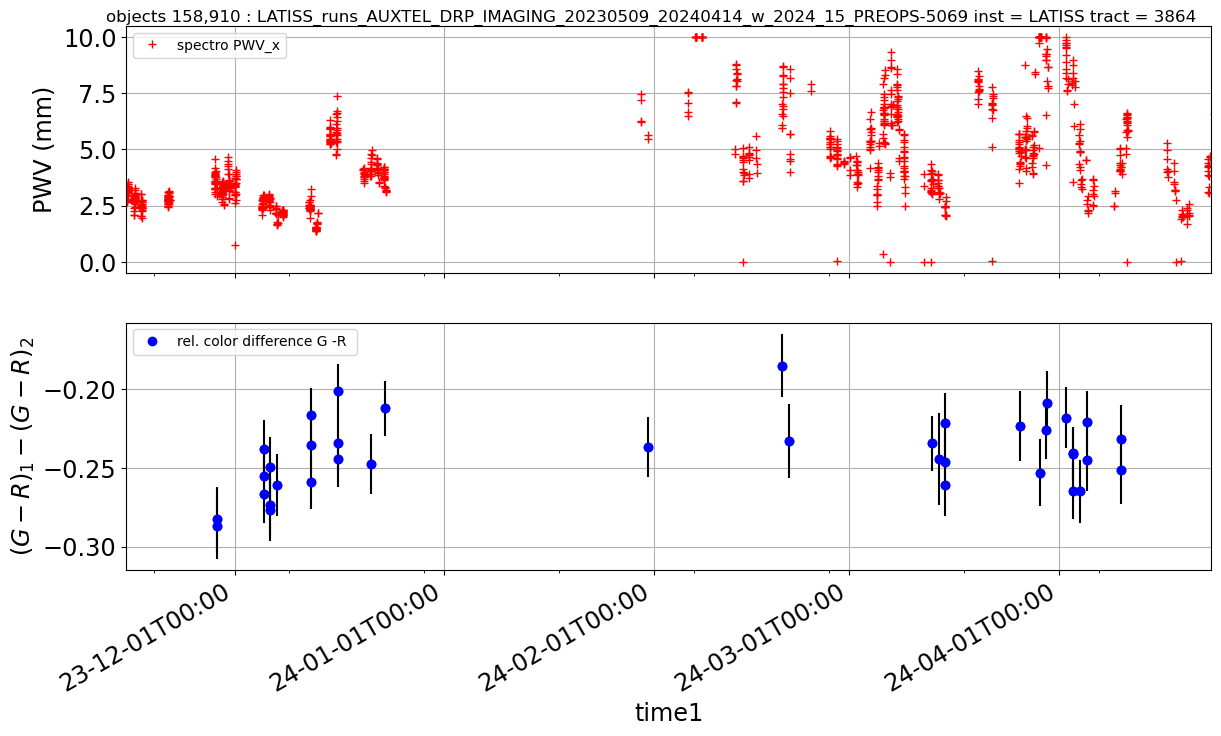

In [115]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)
ax1,ax2  = axs
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")
df_col_gr.plot(x="time1",y="apcol12_s12",ax=ax2,marker="o",c="b",lw=0.0,grid=True,label="rel. color difference G -R ")
ax2.errorbar(df_col_gr.time1,df_col_gr.apcol12_s12,yerr=df_col_gr.apcol12Err_s12,color="b",ecolor="k",fmt="o")
ax2.set_xlabel("time1")
ax2.xaxis.set_major_formatter(date_form)

tmin = df_col_gr["time1"].min()
tmax = df_col_gr["time1"].max()
dt = tmax-tmin
tmin = tmin-dt/10
tmax = tmax+dt/10

ax2.set_xlim(tmin,tmax)
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax2.legend(loc="upper left")
ax2.set_ylabel("$(G-R)_1-(G-R)_2$")
title = f"objects {objectname1},{objectname2} : " + suptitle
plt.suptitle(title,y=0.9)

### G - Y bands

In [116]:
dfg_y = dfg_rzy[["time","nightObs_y","visit_y","time_y","dtsec_y"]] 
dfg_y.head()

time nightObs_y visit_y  \
nightObs visit                                                            
20231115 2023111500494 2023-11-16 07:24:27.061498112        NaN     NaN   
         2023111500497 2023-11-16 07:27:28.094509056        NaN     NaN   
         2023111500512 2023-11-16 07:42:58.140508928        NaN     NaN   
         2023111500518 2023-11-16 07:49:11.978504960        NaN     NaN   
         2023111500521 2023-11-16 07:52:18.278995968        NaN     NaN   

                       time_y dtsec_y  
nightObs visit                         
20231115 2023111500494    NaN     NaN  
         2023111500497    NaN     NaN  
         2023111500512    NaN     NaN  
         2023111500518    NaN     NaN  
         2023111500521    NaN     NaN

#### select close measurement in time

In [117]:
dfg_y_sel = dfg_y[np.abs(dfg_y["dtsec_y"]<3600)]

In [118]:
dfg_y_sel.head()

time nightObs_y  \
nightObs visit                                                    
20231121 2023112100510 2023-11-22 07:05:45.944507904   20231121   
         2023112100514 2023-11-22 07:09:39.352001024   20231121   
20231127 2023112700297 2023-11-28 06:42:48.618001920   20231127   
         2023112700301 2023-11-28 06:46:40.718000128   20231127   
         2023112700305 2023-11-28 06:50:36.921509120   20231127   

                              visit_y                         time_y  \
nightObs visit                                                         
20231121 2023112100510  2023112100513  2023-11-22T07:08:07.767494912   
         2023112100514  2023112100513  2023-11-22T07:08:07.767494912   
20231127 2023112700297  2023112700296  2023-11-28T06:41:22.040489984   
         2023112700301  2023112700304  2023-11-28T06:49:01.705502976   
         2023112700305  2023112700304  2023-11-28T06:49:01.705502976   

                           dtsec_y  
nightObs visit                      
20231121 2023112100510  141.822987  
         2023112100514  -91.584507  
20231127 2023112700297  -86.577512  
         2023112700301  140.987502  
         2023112700305  -95.216007

In [119]:
#df_col_gy = GetFluxes2StarsTwoBands("g","y",dfg_y_sel,df_g,df_y)
df_col_gy = GetFluxes2StarsTwoBandsNoCutout("g","y",dfg_y_sel,df_g,df_y)

0 (20231121, 2023112100510)
======================= night :: 20231121 ==> (g,y) = (2023112100510,2023112100513) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
1 (20231121, 2023112100514)
======================= night :: 20231121 ==> (g,y) = (2023112100514,2023112100513) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
2 (20231127, 2023112700297)
======================= night :: 20231127 ==> (g,y) = (2023112700297,2023112700296) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
3 (20231127, 2023112700301)
======================= night :: 20231127 ==> (g,y) = (2023112700301,2023112700304) =============================
4 (20231127, 2023112700305)
======================= night :: 20231127 ==> (g,y) = (2023112700305

In [120]:
df_col_gy.head()

,band1,exposure1,time1,psfMag11,psfMag12,psfMagErr11,psfMagErr12,apMag11,apMag12,apMagErr11,apMagErr12,band2,exposure2,time2,psfMag21,psfMag22,psfMagErr21,psfMagErr22,apMag21,apMag22,apMagErr21,apMagErr22,dt,deltapsfmag_s12b1,deltapsfmagErr_s12b1,deltaapmag_s12b1,deltaapmagErr_s12b1,deltapsfmag_s12b2,deltapsfmagErr_s12b2,deltaapmag_s12b2,deltaapmagErr_s12b2,psfcol12_s1,psfcol12Err_s1,apcol12_s1,apcol12Err_s1,psfcol12_s2,psfcol12Err_s2,apcol12_s2,apcol12Err_s2,psfcol12_s12,psfcol12Err_s12,apcol12_s12,apcol12Err_s12
0,g,2023112700301,2023-11-28 06:46:40.718000128,15.382085,16.319760,0.005090,0.008553,-12.680936,-11.736817,0.007132,0.017017,y,2023112700304,2023-11-28 06:49:01.705502976,14.333603,14.664893,0.007457,0.009307,-11.946985,-11.621661,0.012130,0.016368,140.987502,-0.937675,0.009953,-0.944118,0.018451,-0.331291,0.011926,-0.325324,0.020373,1.048482,0.009028,-0.733951,0.014071,1.654867,0.012641,-0.115157,0.023611,-0.606384,0.015533,-0.618794,0.027486
1,g,2023112700341,2023-11-28 07:21:02.903995904,15.413407,16.340475,0.004857,0.008000,-12.692943,-11.750858,0.007401,0.017624,y,2023112700340,2023-11-28 07:19:31.999005952,14.323674,14.644721,0.007040,0.008333,-11.968375,-11.638481,0.012541,0.016993,-90.904990,-0.927067,0.009359,-0.942086,0.019115,-0.321047,0.010909,-0.329894,0.021119,1.089733,0.008553,-0.724568,0.014561,1.695753,0.011552,-0.112376,0.024482,-0.606020,0.014373,-0.612192,0.028485
2,g,2023120400585,2023-12-05 07:14:47.779991040,15.433164,16.355227,0.004702,0.007544,-12.682146,-11.773033,0.006529,0.015084,y,2023120400588,2023-12-05 07:17:09.400504064,14.332164,14.649612,0.006904,0.008137,-11.913128,-11.638558,0.012386,0.015950,141.620513,-0.922062,0.008889,-0.909114,0.016436,-0.317449,0.010671,-0.274570,0.020195,1.101001,0.008353,-0.769018,0.014002,1.705614,0.011096,-0.134474,0.021953,-0.604614,0.013889,-0.634544,0.026038
3,g,2023120400589,2023-12-05 07:18:34.897998080,15.441978,16.355929,0.004591,0.007468,-12.677808,-11.740875,0.006790,0.016093,y,2023120400588,2023-12-05 07:17:09.400504064,14.332164,14.649612,0.006904,0.008137,-11.913128,-11.638558,0.012386,0.015950,-85.497495,-0.913951,0.008767,-0.936933,0.017467,-0.317449,0.010671,-0.274570,0.020195,1.109815,0.008291,-0.764680,0.014125,1.706317,0.011045,-0.102316,0.022658,-0.596503,0.013811,-0.662363,0.026701
4,g,2023120400593,2023-12-05 07:22:23.009996032,15.477537,16.396433,0.004610,0.007391,-12.669383,-11.737846,0.006411,0.015120,y,2023120400592,2023-12-05 07:20:56.460508928,14.323233,14.640939,0.006954,0.008231,-11.956119,-11.650326,0.012408,0.016444,-86.549488,-0.918896,0.008711,-0.931537,0.016423,-0.317706,0.010776,-0.305793,0.020600,1.154304,0.008344,-0.713264,0.013966,1.755493,0.011063,-0.087520,0.022339,-0.601189,0.013856,-0.625744,0.026345


Text(0.5, 0.9, 'objects 158,910 : LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

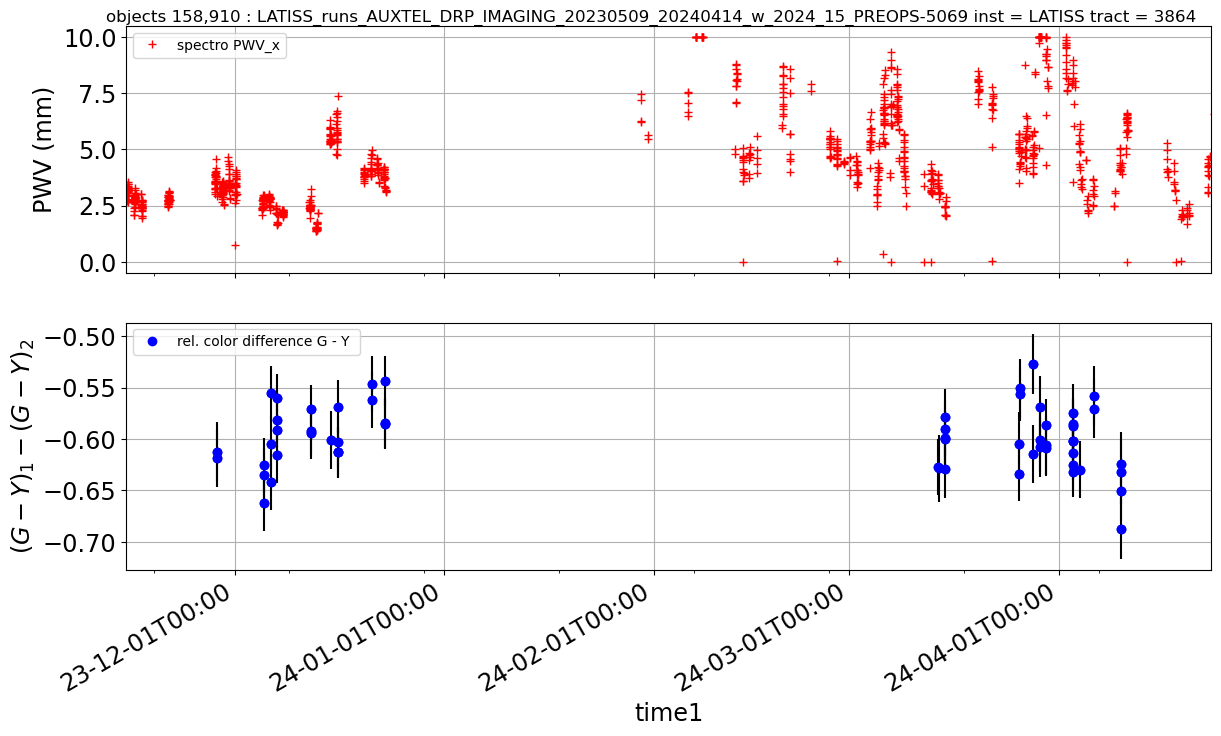

In [121]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)
ax1,ax2  = axs
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")
df_col_gy.plot(x="time1",y="apcol12_s12",ax=ax2,marker="o",c="b",lw=0.0,grid=True,label="rel. color difference G - Y ")
ax2.errorbar(df_col_gy.time1,df_col_gy.apcol12_s12,yerr=df_col_gy.apcol12Err_s12,color="b",ecolor="k",fmt="o")
ax2.set_xlabel("time1")
ax2.xaxis.set_major_formatter(date_form)

tmin = df_col_gy["time1"].min()
tmax = df_col_gy["time1"].max()
dt = tmax-tmin
tmin = tmin-dt/10
tmax = tmax+dt/10

ax2.set_xlim(tmin,tmax)
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax2.legend(loc="upper left")
ax2.set_ylabel("$(G-Y)_1-(G-Y)_2$")
title = f"objects {objectname1},{objectname2} : " + suptitle
plt.suptitle(title,y=0.9)

### R - Y bands

In [122]:
dfr_y = dfr_zy[["time","nightObs_y","visit_y","time_y","dtsec_y"]] 
dfr_y.head()

time nightObs_y  \
nightObs visit                                                    
20231115 2023111500498 2023-11-16 07:28:14.769003008        NaN   
         2023111500522 2023-11-16 07:53:04.747996928        NaN   
20231120 2023112000320 2023-11-21 07:29:44.874492928        NaN   
         2023112000329 2023-11-21 07:39:03.734505984        NaN   
20231121 2023112100515 2023-11-22 07:10:25.908503040   20231121   

                              visit_y                         time_y  \
nightObs visit                                                         
20231115 2023111500498            NaN                            NaN   
         2023111500522            NaN                            NaN   
20231120 2023112000320            NaN                            NaN   
         2023112000329            NaN                            NaN   
20231121 2023112100515  2023112100513  2023-11-22T07:08:07.767494912   

                           dtsec_y  
nightObs visit                      
20231115 2023111500498         NaN  
         2023111500522         NaN  
20231120 2023112000320         NaN  
         2023112000329         NaN  
20231121 2023112100515 -138.141009

In [123]:
dfr_y_sel = dfr_y[np.abs(dfr_y["dtsec_y"])<3600]

In [124]:
#df_col_ry = GetFluxes2StarsTwoBands("r","y",dfr_y_sel,df_r,df_y)
df_col_ry = GetFluxes2StarsTwoBandsNoCutout("r","y",dfr_y_sel,df_r,df_y)

0 (20231121, 2023112100515)
======================= night :: 20231121 ==> (r,y) = (2023112100515,2023112100513) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
1 (20231121, 2023112100551)
======================= night :: 20231121 ==> (r,y) = (2023112100551,2023112100549) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
2 (20231127, 2023112700302)
======================= night :: 20231127 ==> (r,y) = (2023112700302,2023112700304) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
3 (20231127, 2023112700306)
======================= night :: 20231127 ==> (r,y) = (2023112700306,2023112700308) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer i

In [125]:
df_col_ry.head() 

,band1,exposure1,time1,psfMag11,psfMag12,psfMagErr11,psfMagErr12,apMag11,apMag12,apMagErr11,apMagErr12,band2,exposure2,time2,psfMag21,psfMag22,psfMagErr21,psfMagErr22,apMag21,apMag22,apMagErr21,apMagErr22,dt,deltapsfmag_s12b1,deltapsfmagErr_s12b1,deltaapmag_s12b1,deltaapmagErr_s12b1,deltapsfmag_s12b2,deltapsfmagErr_s12b2,deltaapmag_s12b2,deltaapmagErr_s12b2,psfcol12_s1,psfcol12Err_s1,apcol12_s1,apcol12Err_s1,psfcol12_s2,psfcol12Err_s2,apcol12_s2,apcol12Err_s2,psfcol12_s12,psfcol12Err_s12,apcol12_s12,apcol12Err_s12
0,r,2023112700338,2023-11-28 07:17:57.176508928,14.674992,15.361457,0.003596,0.004975,-13.206412,-12.531303,0.004570,0.008511,y,2023112700340,2023-11-28 07:19:31.999005952,14.323674,14.644721,0.007040,0.008333,-11.968375,-11.638481,0.012541,0.016993,94.822497,-0.686465,0.006138,-0.675109,0.009660,-0.321047,0.010909,-0.329894,0.021119,0.351318,0.007905,-1.238037,0.013347,0.716736,0.009705,-0.892822,0.019005,-0.365418,0.012517,-0.345215,0.023224
1,r,2023112700346,2023-11-28 07:25:40.615503872,14.647225,15.322836,0.003654,0.005015,-13.235614,-12.539622,0.004297,0.008157,y,2023112700348,2023-11-28 07:27:15.565991936,14.284547,14.613036,0.007342,0.008855,-11.936109,-11.635590,0.012031,0.015867,94.950488,-0.675610,0.006205,-0.695992,0.009220,-0.328489,0.011503,-0.300520,0.019912,0.362679,0.008201,-1.299505,0.012775,0.709799,0.010176,-0.904032,0.017841,-0.347121,0.013070,-0.395473,0.021943
2,r,2023112700358,2023-11-28 07:37:10.383496960,14.654219,15.337486,0.003802,0.005144,-13.210217,-12.515670,0.004323,0.008196,y,2023112700360,2023-11-28 07:38:45.680006912,14.359076,14.687067,0.007411,0.008829,-11.922966,-11.617794,0.011893,0.015753,95.296509,-0.683267,0.006397,-0.694547,0.009267,-0.327991,0.011527,-0.305172,0.019739,0.295143,0.008329,-1.287251,0.012655,0.650419,0.010218,-0.897876,0.017758,-0.355276,0.013183,-0.389374,0.021806
3,r,2023120400586,2023-12-05 07:15:34.482998016,14.675098,15.348644,0.003535,0.004827,-13.208461,-12.537421,0.004261,0.007906,y,2023120400588,2023-12-05 07:17:09.400504064,14.332164,14.649612,0.006904,0.008137,-11.913128,-11.638558,0.012386,0.015950,94.917506,-0.673546,0.005983,-0.671040,0.008981,-0.317449,0.010671,-0.274570,0.020195,0.342934,0.007756,-1.295333,0.013099,0.699031,0.009462,-0.898862,0.017802,-0.356097,0.012234,-0.396471,0.022102
4,r,2023120400590,2023-12-05 07:19:21.850491904,14.659280,15.331730,0.003514,0.004789,-13.211455,-12.529572,0.004379,0.008206,y,2023120400592,2023-12-05 07:20:56.460508928,14.323233,14.640939,0.006954,0.008231,-11.956119,-11.650326,0.012408,0.016444,94.610017,-0.672450,0.005940,-0.681883,0.009301,-0.317706,0.010776,-0.305793,0.020600,0.336047,0.007792,-1.255336,0.013158,0.690790,0.009523,-0.879246,0.018378,-0.354744,0.012305,-0.376090,0.022602


In [126]:
df_col_ry = df_col_ry[np.abs(df_col_ry["dt"])<3600]

Text(0.5, 0.9, 'objects 158,910 : LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

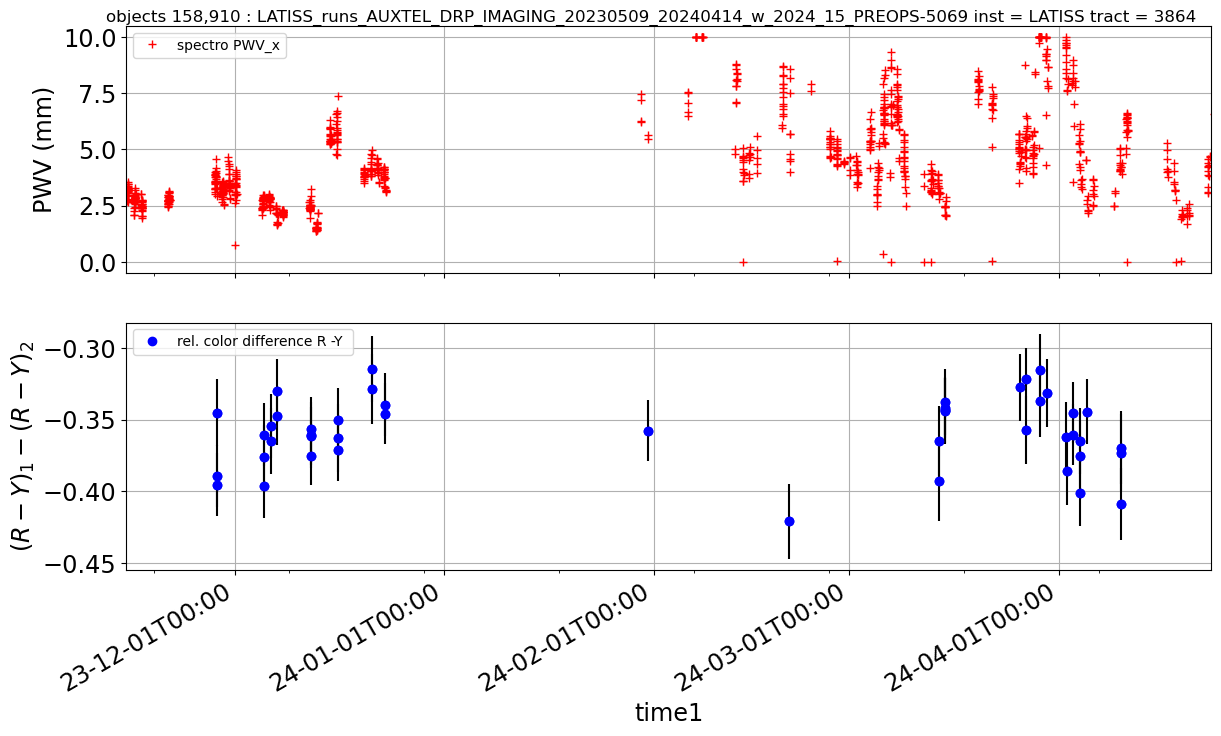

In [127]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)
ax1,ax2  = axs
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")
df_col_ry.plot(x="time1",y="apcol12_s12",ax=ax2,marker="o",c="b",lw=0.0,grid=True,label="rel. color difference R -Y ")
ax2.errorbar(df_col_ry.time1,df_col_ry.apcol12_s12,yerr=df_col_ry.apcol12Err_s12,color="b",ecolor="k",fmt="o")
ax2.set_xlabel("time1")
ax2.xaxis.set_major_formatter(date_form)

tmin = df_col_gy["time1"].min()
tmax = df_col_gy["time1"].max()
dt = tmax-tmin
tmin = tmin-dt/10
tmax = tmax+dt/10

ax2.set_xlim(tmin,tmax)

ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax2.legend(loc="upper left")
ax2.set_ylabel("$(R-Y)_1-(R-Y)_2$")
title = f"objects {objectname1},{objectname2} : " + suptitle
plt.suptitle(title,y=0.9)

### Z - Y bands

In [128]:
#dfz_y = dfz_y[["time","nightObs_y","visit_y","time_y","dtsec_y"]] 
dfz_y.head()

time nightObs_y  \
nightObs visit                                                    
20231121 2023112100512 2023-11-22 07:07:19.090006016   20231121   
         2023112100516 2023-11-22 07:11:12.433499904   20231121   
         2023112100520 2023-11-22 07:15:09.515495936   20231121   
         2023112100552 2023-11-22 07:46:17.304496128   20231121   
20231127 2023112700291 2023-11-28 06:36:45.996996096   20231127   

                              visit_y                         time_y  \
nightObs visit                                                         
20231121 2023112100512  2023112100513  2023-11-22T07:08:07.767494912   
         2023112100516  2023112100513  2023-11-22T07:08:07.767494912   
         2023112100520  2023112100513  2023-11-22T07:08:07.767494912   
         2023112100552  2023112100549  2023-11-22T07:43:14.763491072   
20231127 2023112700291  2023112700296  2023-11-28T06:41:22.040489984   

                           dtsec_y  
nightObs visit                      
20231121 2023112100512   48.677488  
         2023112100516 -184.666005  
         2023112100520 -421.748002  
         2023112100552 -182.541006  
20231127 2023112700291  276.043493

In [129]:
dfz_y_sel = dfz_y[np.abs(dfz_y["dtsec_y"])<3600]

In [130]:
#dfz_y_sel

In [131]:
#df_col_zy = GetFluxes2StarsTwoBands("z","y",dfz_y_sel,df_z,df_y)
df_col_zy = GetFluxes2StarsTwoBandsNoCutout("z","y",dfz_y_sel,df_z,df_y)

0 (20231121, 2023112100512)
======================= night :: 20231121 ==> (z,y) = (2023112100512,2023112100513) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
1 (20231121, 2023112100516)
======================= night :: 20231121 ==> (z,y) = (2023112100516,2023112100513) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
2 (20231121, 2023112100520)
======================= night :: 20231121 ==> (z,y) = (2023112100520,2023112100513) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer is out-of-bounds
3 (20231121, 2023112100552)
======================= night :: 20231121 ==> (z,y) = (2023112100552,2023112100549) =============================
<class 'IndexError'>
('single positional indexer is out-of-bounds',)
single positional indexer i

In [132]:
df_col_zy = df_col_zy[np.abs(df_col_zy["dt"])<3600]

Text(0.5, 0.9, 'objects 158,910 : LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

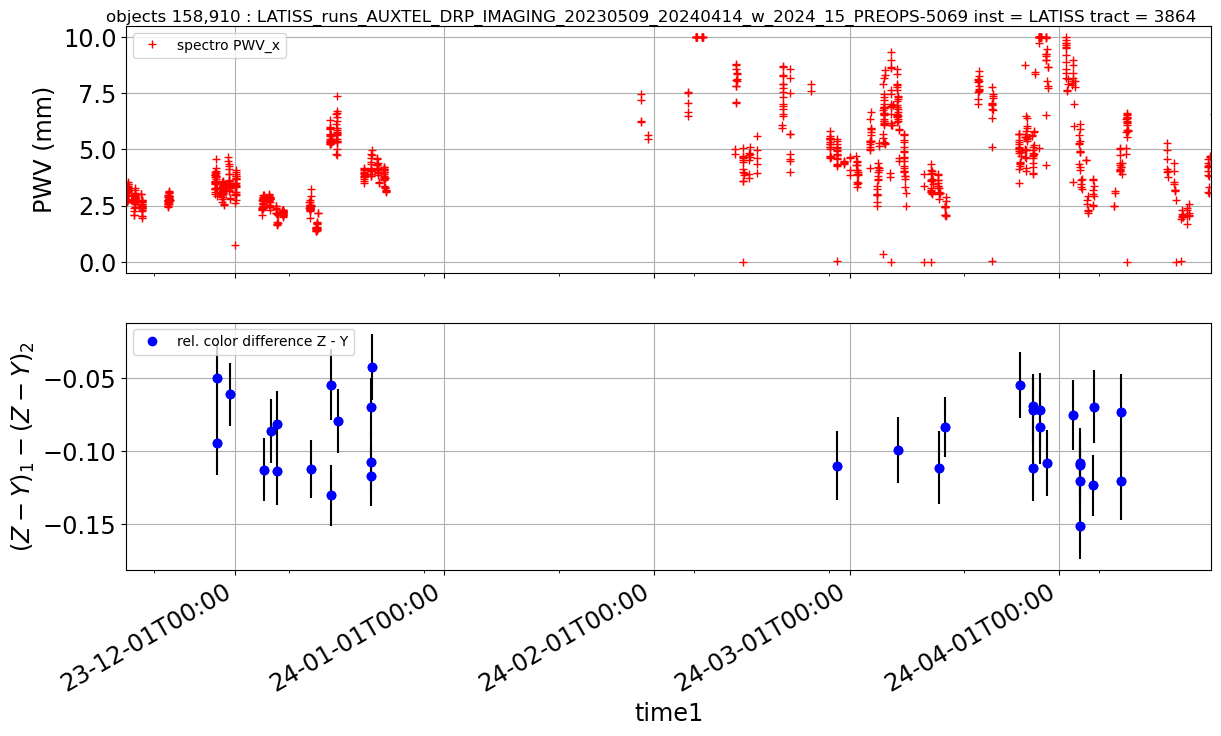

In [133]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")
fig,axs = plt.subplots(2,1,figsize=(14,8),sharex=True)
ax1,ax2  = axs
df_spec.plot(x="Time",y="PWV [mm]_x",ax=ax1,marker='+',c="r",lw=0.0,grid=True,label="spectro PWV_x")
df_col_zy.plot(x="time1",y="apcol12_s12",ax=ax2,marker="o",c="b",lw=0.0,grid=True,label="rel. color difference Z - Y")
ax2.errorbar(df_col_zy.time1,df_col_zy.apcol12_s12,yerr=df_col_zy.apcol12Err_s12,color="b",ecolor="k",fmt="o")
ax2.set_xlabel("time1")
ax2.xaxis.set_major_formatter(date_form)

tmin = df_col_zy["time1"].min()
tmax = df_col_zy["time1"].max()
dt = tmax-tmin
tmin = tmin-dt/10
tmax = tmax+dt/10

ax2.set_xlim(tmin,tmax)
ax1.legend(loc="upper left")
ax1.set_ylabel("PWV (mm)")
ax2.legend(loc="upper left")
ax2.set_ylabel("$(Z-Y)_1-(Z-Y)_2$")
title = f"objects {objectname1},{objectname2} : " + suptitle
plt.suptitle(title,y=0.9)